In [1]:
import os
import sys
# !{sys.executable} -m pip install python-csv
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install pandas;
# print(pd.__version__)

In [12]:
from lib.display import Display
from lib.mock_db import Database
from lib.schema import Schema

db = Database(Schema.ECOV)   
Display.header('eCOV study on ALP', 'h1')

Display.header('Participants', 'h3')
original_participants_df = db.get_participants()
Display.frame(original_participants_df, 5)
print('Number of participants:', original_participants_df.shape[0])

Display.header('Responses', 'h3')
responses_df = db.get_responses()
Display.frame(responses_df.drop(columns=['QUESTIONNAIRE_ID']), 5)
print('Number of responses:', responses_df.shape[0])

,Unnamed: 0,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE
0,1,4769,NaN,enrolled,2021-08-22,NaT
1,2,3368,NaN,enrolled,2021-08-15,NaT
2,3,8377,anonymous,enrolled,2021-12-14,NaT
3,4,4622,NaN,enrolled,2021-08-18,NaT
4,5,4724,NaN,enrolled,2021-08-22,NaT


Number of participants: 8940


,Unnamed: 0,ALP_ID,VERSION,AUTHORED,QUESTIONNAIRE,LINK_ID,VALUE,VALUECODING_CODE,LANGUAGE,TEXT
0,1,1496,1.2.0,2021-08-11,corona_testing_and_symptoms,are_new_symptoms,NaN,no,de,"In den letzten 7 Tagen: Hatten Sie neu aufgetretene Symptome (z.B. Husten, Fieber, Halsschmerzen, Schnupfen)?"
1,2,1496,1.2.0,2021-08-11,corona_testing_and_symptoms,did_get_tested,NaN,no,de,In den letzten 7 Tagen: Wurden Sie auf SARS-CoV-2 getestet?
2,3,1496,1.2.0,2021-07-07,corona_testing_and_symptoms,are_new_symptoms,NaN,no,de,"In den letzten 7 Tagen: Hatten Sie neu aufgetretene Symptome (z.B. Husten, Fieber, Halsschmerzen, Schnupfen)?"
3,4,1496,1.2.0,2021-07-07,corona_testing_and_symptoms,did_get_tested,NaN,no,de,In den letzten 7 Tagen: Wurden Sie auf SARS-CoV-2 getestet?
4,5,1496,1.2.0,2021-08-05,covid_second_vaccine,has_received_second_vacciation,NaN,no,de,Haben Sie die zweite Impfung gegen COVID-19 erhalten?


Number of responses: 431162


In [13]:
from lib.display import Display
from lib.studies.ecov_study import EcovStudy
from lib.participant_builder import ParticipantsBuilder, FilterUsers
from lib.ecov_utils import Vaccination, ResponsesBuilder, TestManager

from datetime import datetime, timedelta
from utils import plot_over_weeks, get_age_group, to_week_number
import pandas as pd
import math 

import matplotlib.pyplot as plt

In [14]:
df = responses_df[responses_df['LINK_ID'] == 'checkin_tests_reported']
print(f'When did we start reminding people to fill on demand in the monthly questionnaire? {df["AUTHORED"].min()}') 

df = responses_df[responses_df['QUESTIONNAIRE'] == 'corona_testing_and_symptoms']
print(f'When did we split tests and symptoms to 2 different questionnaires? {df["AUTHORED"].max()}') 

temp = df[df['ALP_ID'] == 1535]
df = temp.groupby('QUESTIONNAIRE_ID').aggregate({'AUTHORED': 'max'}).sort_values(by='AUTHORED')
# Display.frame(df, 20)

When did we start reminding people to fill on demand in the monthly questionnaire? 2021-09-21 00:00:00
When did we split tests and symptoms to 2 different questionnaires? 2021-11-10 00:00:00


In [15]:
df = responses_df[['ALP_ID', 'AUTHORED']].drop_duplicates().reset_index(drop=True)
df['WEEKEND'] = (df['AUTHORED'].dt.weekday > 5) * 1
df['WEEKDAY'] = (df['AUTHORED'].dt.weekday <= 5) * 1
df = df.groupby(['ALP_ID']).aggregate({'WEEKEND': 'sum', 'WEEKDAY': 'sum'})
df['PERCENT'] = round(100*df['WEEKEND']/df['WEEKDAY'], 1)
print(df[df['PERCENT'] > 28].shape[0])
print(df.shape[0])

87
8571


In [16]:
print(f'All users: {original_participants_df.shape[0]}')
df_no_start_date = original_participants_df[pd.isnull(original_participants_df['START_DATE'])]
print(f'Users without start date: {df_no_start_date.shape[0]}')
df_revoked_consent = original_participants_df[original_participants_df['STATUS'] == 'withdrawn']

All users: 8940
Users without start date: 550


In [17]:
df = responses_df.groupby(['ALP_ID', 'QUESTIONNAIRE']) \
        .aggregate({'AUTHORED': 'min'}) \
        .reset_index()
df = df[df['QUESTIONNAIRE'] == 'personal_info']
print(f'All users: {original_participants_df.shape[0]}')
print(f'Users without demographics: {original_participants_df.shape[0] - df.shape[0]}')

# Display.frame(df, 5)
Display.header('Users enrolled', 'h2')
print(f'All Users with data (submitted demographics): {df.shape[0]}')
print(f'Users enrolled in 2021: {df[df["AUTHORED"] < datetime(2022, 1, 1)].shape[0]}')
print(f'Users enrolled in 2022: {df[df["AUTHORED"] >= datetime(2022, 1, 1)].shape[0]}')

df = responses_df.groupby(['ALP_ID', 'AUTHORED', 'QUESTIONNAIRE_ID']) \
        .aggregate({'LINK_ID': 'nunique'}) \
        .reset_index()[['ALP_ID', 'AUTHORED', 'LINK_ID']] \
        .rename(columns={'LINK_ID': 'COUNT_QUESTIONS'}) \

# Display.frame(df, 5)
Display.header('Questions donated', 'h2')
print(f'Number of questions doanted: {df["COUNT_QUESTIONS"].count()}')
responses_2021_df = df[df['AUTHORED'] < datetime(2022, 1, 1)]
print(f'Number of questions doanted in 2021: {responses_2021_df["COUNT_QUESTIONS"].count()}')
responses_2022_df = df[df['AUTHORED'] >= datetime(2022, 1, 1)]
print(f'Number of questions doanted in 2022: {responses_2022_df["COUNT_QUESTIONS"].count()}')

All users: 8940
Users without demographics: 379


All Users with data (submitted demographics): 8561
Users enrolled in 2021: 1323
Users enrolled in 2022: 0


Number of questions doanted: 23344
Number of questions doanted in 2021: 20553
Number of questions doanted in 2022: 2791


In [18]:
df = responses_df[(responses_df['ALP_ID'] == 2129) & (responses_df['AUTHORED'] == '2022-01-12')]
Display.frame(df)

,Unnamed: 0,ALP_ID,VERSION,AUTHORED,QUESTIONNAIRE,LINK_ID,VALUE,VALUECODING_CODE,LANGUAGE,TEXT,QUESTIONNAIRE_ID
42255,42256,2129,1.2.0,2022-01-12,corona_testing,what_test_method,NaN,antigen_test,de,Mit welchem Testverfahren?,DQjdR6HZ22hjejgZGjnoSVC8TAK2nwaYEKFDaboFstM/UQO/Ffev0lNRBKYWyrWKXsEFhTf3tsCfk8mgY/xjNc3mQq+Hx6eW0sODYsjmIw3nvZxxq9Zql1Z9ecNREh2Xc/j53N5Q4j/OMhTzotzi640DVnz0iucAlhlmMxPv44mGQN+SgM6xLxcPNm2ICozktQN9O1hvPJm4uQIevscpL6pmecOSO34sIv6BjdWHJevqMEgcIFH1YK63uQTkKGoiwNZftrFGse+Hkn+G7VgW9C9ZKslnkg9peVN8rgpqlgMdKzARkJWQDaH3Mx7nQWErSJwtwuFfePlKQQjpbsm6nQ==
42256,42257,2129,1.2.0,2022-01-12,corona_testing,corona_test_result,NaN,test_result_neg,de,Wie war Ihr Testergebnis?,DQjdR6HZ22hjejgZGjnoSVC8TAK2nwaYEKFDaboFstM/UQO/Ffev0lNRBKYWyrWKXsEFhTf3tsCfk8mgY/xjNc3mQq+Hx6eW0sODYsjmIw3nvZxxq9Zql1Z9ecNREh2Xc/j53N5Q4j/OMhTzotzi640DVnz0iucAlhlmMxPv44mGQN+SgM6xLxcPNm2ICozktQN9O1hvPJm4uQIevscpL6pmecOSO34sIv6BjdWHJevqMEgcIFH1YK63uQTkKGoiwNZftrFGse+Hkn+G7VgW9C9ZKslnkg9peVN8rgpqlgMdKzARkJWQDaH3Mx7nQWErSJwtwuFfePlKQQjpbsm6nQ==
42257,42258,2129,1.2.0,2022-01-12,corona_testing,when_tested_on_demand,2022-01-10,NaN,de,Wann wurde der Test durchgefÃ¼hrt?,DQjdR6HZ22hjejgZGjnoSVC8TAK2nwaYEKFDaboFstM/UQO/Ffev0lNRBKYWyrWKXsEFhTf3tsCfk8mgY/xjNc3mQq+Hx6eW0sODYsjmIw3nvZxxq9Zql1Z9ecNREh2Xc/j53N5Q4j/OMhTzotzi640DVnz0iucAlhlmMxPv44mGQN+SgM6xLxcPNm2ICozktQN9O1hvPJm4uQIevscpL6pmecOSO34sIv6BjdWHJevqMEgcIFH1YK63uQTkKGoiwNZftrFGse+Hkn+G7VgW9C9ZKslnkg9peVN8rgpqlgMdKzARkJWQDaH3Mx7nQWErSJwtwuFfePlKQQjpbsm6nQ==
42258,42259,2129,1.1.1,2022-01-12,covid_exposition,mask_washing,NaN,times_6_to_10,de,In den letzten 7 Tagen: Wie hÃ¤ufig haben Sie Ihren Mund-Nasen-Schutz gewechselt oder gewaschen?,NmHV6VpYXg6fdE5K1KuC1QCkJvlQxvliWH4yGdueP5k5fvaTD/XUanFeldjw3jPZxooUDalYQiO2tToZgsilEFAMrjrJZNamcBTECt23o8Xis4u7VZnMH1m0kGWvLGZdZEITCaZUPIK+uz5o+DXD6nVaOyx5my+Nb3ghwv74RCGHmvosVtyUcQdcph1Jd7YD02sCwCbAz0ykZmO9RsTVBofUdJLBrkRfq8U/1PdUL6hjQEmss+7cHYpU7+Q0+6MVeY9Ae+wx0CFv1GlUX5njy2RCyDbIsGCbyEkbN1fyztI7YI55BspCpKqdBGhC7+MOGloccAbA8K6z6f5yC6PdWQ==
42259,42260,2129,1.1.1,2022-01-12,covid_exposition,infected_person_contact,NaN,no,de,In den letzten 4 Wochen: Hatten Sie Kontakt zu einer Person mit bestÃ¤tigter aktiver SARS-CoV-2-Infektion?,NmHV6VpYXg6fdE5K1KuC1QCkJvlQxvliWH4yGdueP5k5fvaTD/XUanFeldjw3jPZxooUDalYQiO2tToZgsilEFAMrjrJZNamcBTECt23o8Xis4u7VZnMH1m0kGWvLGZdZEITCaZUPIK+uz5o+DXD6nVaOyx5my+Nb3ghwv74RCGHmvosVtyUcQdcph1Jd7YD02sCwCbAz0ykZmO9RsTVBofUdJLBrkRfq8U/1PdUL6hjQEmss+7cHYpU7+Q0+6MVeY9Ae+wx0CFv1GlUX5njy2RCyDbIsGCbyEkbN1fyztI7YI55BspCpKqdBGhC7+MOGloccAbA8K6z6f5yC6PdWQ==
42260,42261,2129,1.1.1,2022-01-12,covid_exposition,how_many_people_in_contact,NaN,6 to 10,de,"In den letzten 7 Tagen: Zu wie vielen Personen auÃerhalb Ihres persÃ¶nlichen Wohnumfelds hatten Sie engen Kontakt (Abstand weniger als 1,5 Meter, jeweils lÃ¤nger als 15 Minuten)?",NmHV6VpYXg6fdE5K1KuC1QCkJvlQxvliWH4yGdueP5k5fvaTD/XUanFeldjw3jPZxooUDalYQiO2tToZgsilEFAMrjrJZNamcBTECt23o8Xis4u7VZnMH1m0kGWvLGZdZEITCaZUPIK+uz5o+DXD6nVaOyx5my+Nb3ghwv74RCGHmvosVtyUcQdcph1Jd7YD02sCwCbAz0ykZmO9RsTVBofUdJLBrkRfq8U/1PdUL6hjQEmss+7cHYpU7+Q0+6MVeY9Ae+wx0CFv1GlUX5njy2RCyDbIsGCbyEkbN1fyztI7YI55BspCpKqdBGhC7+MOGloccAbA8K6z6f5yC6PdWQ==
42261,42262,2129,1.1.1,2022-01-12,covid_exposition,public_transport,NaN,Rarely,de,In den letzten 7 Tagen: Wie hÃ¤ufig haben Sie Ã¶ffentliche Verkehrsmittel benutzt?,NmHV6VpYXg6fdE5K1KuC1QCkJvlQxvliWH4yGdueP5k5fvaTD/XUanFeldjw3jPZxooUDalYQiO2tToZgsilEFAMrjrJZNamcBTECt23o8Xis4u7VZnMH1m0kGWvLGZdZEITCaZUPIK+uz5o+DXD6nVaOyx5my+Nb3ghwv74RCGHmvosVtyUcQdcph1Jd7YD02sCwCbAz0ykZmO9RsTVBofUdJLBrkRfq8U/1PdUL6hjQEmss+7cHYpU7+Q0+6MVeY9Ae+wx0CFv1GlUX5njy2RCyDbIsGCbyEkbN1fyztI7YI55BspCpKqdBGhC7+MOGloccAbA8K6z6f5yC6PdWQ==
42262,42263,2129,1.1.1,2022-01-12,covid_exposition,checkin_symptoms_reported,NaN,no,de,"Hatten Sie in den letzten 4 Wochen Krankheitssymptome, die Sie noch nicht eingegeben haben?",NmHV6VpYXg6fdE5K1KuC1QCkJvlQxvliWH4yGdueP5k5fvaTD/XUanFeldjw3jPZxooUDalYQiO2tToZgsilEFAMrjrJZNamcBTECt23o8Xis4u7VZnMH1m0kGWv

In [19]:
study = EcovStudy()
print('Study:', study.name())
print('Last donation:', responses_df['AUTHORED'].max().strftime("%Y-%m-%d"))

builder = ParticipantsBuilder(study, original_participants_df, responses_df)
participants_df = builder \
    .add_last_donation() \
    .add_all_submissions() \
    .get() \
    .sort_values(by=['Q3'], ascending=False)

Display.header('Participants, enrollment and last donation', 'h2')
Display.frame(participants_df, 6)
Display.text('Number of users: %d' % participants_df.shape[0])

df = participants_df[participants_df['STATUS'] != 'enrolled']
Display.text(f'Left the study: {df.shape[0]}')

Study: eCOV
Last donation: 2022-03-09


,Unnamed: 0,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,LAST_DONATION,all,Q1,Q2,Q3,Q4a,Q4b,Q5a,Q5b,Q6
6329,6330,2073,anonymous,enrolled,2021-06-01,NaT,2021-06-01,2022-02-18,35,1,10,10,1,1,1,1,10
1346,1347,1638,NaN,enrolled,2021-05-17,NaT,2021-05-17,2022-02-10,28,1,13,10,1,1,1,1,0
7491,7492,1786,anonymous,enrolled,2021-05-05,NaT,2021-05-05,2022-02-22,56,1,15,10,4,1,1,1,23
2026,2027,2247,NaN,enrolled,2021-05-19,NaT,2021-05-19,2022-02-23,37,1,10,10,1,2,1,1,11
1666,1667,1661,NaN,enrolled,2021-05-22,NaT,2021-05-22,2022-02-09,37,1,13,10,4,3,1,0,5
1680,1681,2916,NaN,enrolled,2021-06-01,NaT,2021-06-01,2022-02-09,47,1,11,10,9,1,1,1,13


In [20]:
# date_str = responses_df['AUTHORED'].max().strftime("%Y-%m-%d")
# original_participants_df.to_csv(f'eCOV/{date_str}-participants.csv', index=False)  

# r_df = responses_df.copy()
# r_df['TEXT'] = r_df['TEXT'].replace('\\n',' ', regex=True)
# r_df['VALUE'] = r_df['VALUE'].replace('\\n',' ', regex=True)
# r_df.to_csv(f'eCOV/{date_str}-responses.csv', index=False)  

In [21]:
from ecov_utils import ResponsesBuilder, TestManager
from datetime import datetime , timedelta

class AnalyzeGoals():
    MIN_TIME = 8 * 7 # 8 weeks  
    
    def __init__(self, study, participants_df, responses_df):
        self.participants_df = participants_df
        self.tests = TestManager(responses_df).get()
        last_donation = self.participants_df['LAST_DONATION'].max()
        self.threshold_day = last_donation - timedelta(days=AnalyzeGoals.MIN_TIME)
        
    def _get_tests_group_criteria(self):
        df = self.tests.groupby('ALP_ID').agg({'TEST_DATE' : ['count']})
        df.reset_index(inplace=True)
        df.columns = ['ALP_ID', 'COUNT_QUEST.']
        df = df[df['COUNT_QUEST.'] >= 2]
        ids = set(df['ALP_ID'].unique())
        return self.participants_df[self.participants_df['ALP_ID'].isin(ids)].copy()

    def print_title(self, title, text):
        print(f'{title + ":":<50} {text}')
        
    def prin_test_criteria(self):
        Display.header('Tests criteria', 'h2')
        self.print_title('Number of tests', f'{self.tests.shape[0]}')
        self.print_title('Number of users reporting tests', f'{len(self.tests["ALP_ID"].unique())}')

        users_fulfill_test_criteria = self._get_tests_group_criteria()
        self.print_title('Number of users reporting at least 2 tests', f'{users_fulfill_test_criteria.shape[0]}')
        percent = round(100 * users_fulfill_test_criteria.shape[0] / self.participants_df.shape[0], 1)
        self.print_title(f'Percentage from {self.participants_df.shape[0]} users', f'{percent}%')
       
    def prin_time_criteria(self):
        Display.header('Participations 8 weeks and more','h2')       
        
        users_enrolled_before_threshold = self.participants_df[self.participants_df['ENROLED_ON'] < self.threshold_day]
        title = f'Enrolled before {self.threshold_day.strftime("%d.%m.%Y")} (>=8 weeks)'
        self.print_title(title, f'{users_enrolled_before_threshold.shape[0]}')
        
        self.participants_df['TIME_IN_STUDY'] = (self.participants_df['LAST_DONATION'] - self.participants_df['ENROLED_ON']).dt.days
        users_enough_time = self.participants_df[self.participants_df['TIME_IN_STUDY'] >= AnalyzeGoals.MIN_TIME]
        users_enough_time = users_enough_time[users_enough_time['ENROLED_ON'] < self.threshold_day]
        title = f'Participating {AnalyzeGoals.MIN_TIME} days or more'
        self.print_title(title, f'{users_enough_time.shape[0]}')
        
        percent = None if users_enrolled_before_threshold.shape[0] == 0 else \
            round(100 * users_enough_time.shape[0] / users_enrolled_before_threshold.shape[0], 1)
        title = f'Percentage from {users_enrolled_before_threshold.shape[0]} users'
        self.print_title(title, f'{percent}%')
        
    def print_okr_criteria(self):
        Display.header('Participations of 8 weeks or report min 2 tests','h2')   
        users_fulfill_test_criteria = self._get_tests_group_criteria()
        users_fulfill_test_criteria['TIME_IN_STUDY'] = (users_fulfill_test_criteria['LAST_DONATION'] - users_fulfill_test_criteria['ENROLED_ON']).dt.days
        tested_short_time_users = users_fulfill_test_criteria[users_fulfill_test_criteria['TIME_IN_STUDY'] < AnalyzeGoals.MIN_TIME]
        title = f'Users tested >=2 and enrolled after {self.threshold_day.strftime("%d.%m.%Y")}'
        self.print_title(title, f'{tested_short_time_users.shape[0]}')
      
        users_enough_time = self.participants_df[self.participants_df['TIME_IN_STUDY'] >= AnalyzeGoals.MIN_TIME]
        count_fulfilling_okrs = users_enough_time.shape[0] + tested_short_time_users.shape[0]
        self.print_title('Users fulfilling at least one criteria', f'{count_fulfilling_okrs}')
        percent = round(100 * count_fulfilling_okrs / self.participants_df.shape[0], 1)
        title = f'Percentage from {self.participants_df.shape[0]} users'
        self.print_title(title, f'{percent}%')
        
    def print_summary(self):
        Display.header('OKRs analysis', 'h1')
        self.print_title('Number of participants', f'{self.participants_df.shape[0]}')
        self.prin_test_criteria()
        self.prin_time_criteria()
        self.print_okr_criteria()

    
pb = ParticipantsBuilder(study, original_participants_df, responses_df).add_last_donation()
participants_df = pb.add_all_submissions().get()
ag = AnalyzeGoals(study, participants_df, responses_df)
ag.print_summary()


Number of participants:                            8940


Number of tests:                                   25996
Number of users reporting tests:                   4870
Number of users reporting at least 2 tests:        3139
Percentage from 8940 users:                        35.1%


Enrolled before 12.01.2022 (>=8 weeks):            1323
Participating 56 days or more:                     776
Percentage from 1323 users:                        58.7%


Users tested >=2 and enrolled after 12.01.2022:    54
Users fulfilling at least one criteria:            830
Percentage from 8940 users:                        9.3%


In [24]:
# participants_df = ParticipantsBuilder(study, original_participants_df, responses_df) \
#     .add_last_donation() \
#     .add_choice('personal_info','study_discovery', 'CHANNEL') \
#     .get()

# p_df = participants_df[participants_df['START_DATE'] >= datetime(2021, 11,22)]
# r_df = responses_df[responses_df['ALP_ID'].isin(p_df['ALP_ID'].unique())]

# ag = AnalyzeGoals(study, p_df, r_df)
# Display.header('OKRs analysis - contribution of public event', 'h2')
# ag.print_title('Number of participants', f'{p_df.shape[0]}')
# ag.prin_test_criteria()
# ag.prin_time_criteria()
# ag.print_okr_criteria()

# import matplotlib.pyplot as plt
# fig, ax1 = plt.subplots(1,1, figsize=(8,7))
# vc = p_df['CHANNEL'].value_counts()
# vc.plot(kind="bar", title='Participants distributed over the channel', ax=ax1, \
#         xlabel='Channel', ylabel='Particiapnts with symptoms');
# Display.tag_bars(ax1)

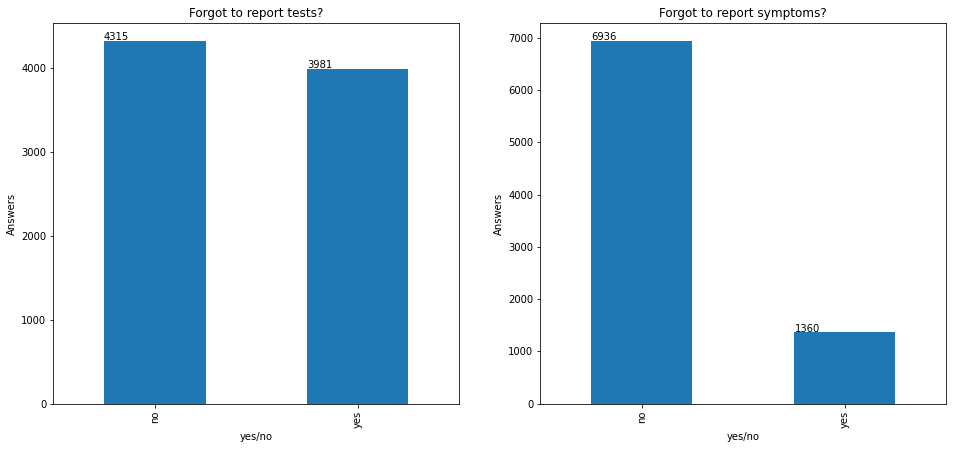

In [25]:
from ecov_utils import ResponsesBuilder
import matplotlib.pyplot as plt

rb = ResponsesBuilder(responses_df)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))

vc = rb.get_choice('T', 'checkin_tests_reported')['T'].value_counts()
vc.plot(kind="bar", title='Forgot to report tests?', ax=ax1, \
        xlabel='yes/no', ylabel='Answers');
Display.tag_bars(ax1)

vc = rb.get_choice('S', 'checkin_symptoms_reported')['S'].value_counts()

vc.plot(kind="bar", title='Forgot to report symptoms?', ax=ax2, \
        xlabel='yes/no', ylabel='Answers');
Display.tag_bars(ax2)

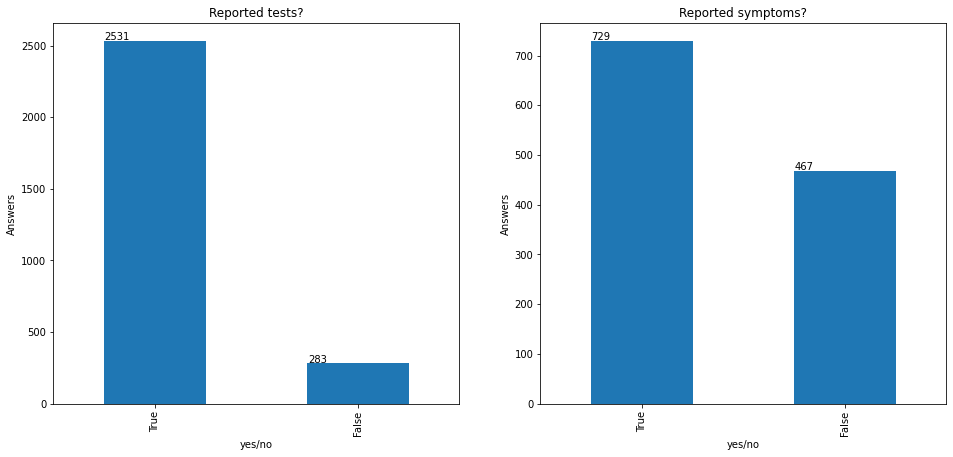

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))

df1 = rb.get_choice('T', 'checkin_tests_reported')
df1 = df1[df1['T'] == 'yes']
df2 = rb.get_answer('test_date', 'when_tested_on_demand')
df2 = df2[['ALP_ID', 'test_date', 'AUTHORED']]

df = pd.merge(df1, df2, how='left', on=['ALP_ID', 'AUTHORED'])
df['added_tests'] = ~pd.isnull(df['test_date'])
df = df.drop_duplicates(subset=['ALP_ID', 'AUTHORED', 'added_tests'], keep='last')

vc = df['added_tests'].value_counts()
vc.plot(kind="bar", title='Reported tests?', ax=ax1, \
        xlabel='yes/no', ylabel='Answers');
Display.tag_bars(ax1)

df1 = rb.get_choice('S', 'checkin_symptoms_reported')
df1 = df1[df1['S'] == 'yes']
df2 = rb.get_choice('symptoms', 'which_new_symptoms')
df2 = df2[['ALP_ID', 'symptoms', 'AUTHORED']]

df = pd.merge(df1, df2, how='left', on=['ALP_ID', 'AUTHORED'])
df['added_symptoms'] = ~pd.isnull(df['symptoms'])
df = df.drop_duplicates(subset=['ALP_ID', 'AUTHORED', 'added_symptoms'], keep='last')

vc = df['added_symptoms'].value_counts()
vc.plot(kind="bar", title='Reported symptoms?', ax=ax2, \
        xlabel='yes/no', ylabel='Answers');
Display.tag_bars(ax2)

All: 8940
No donations: 7612


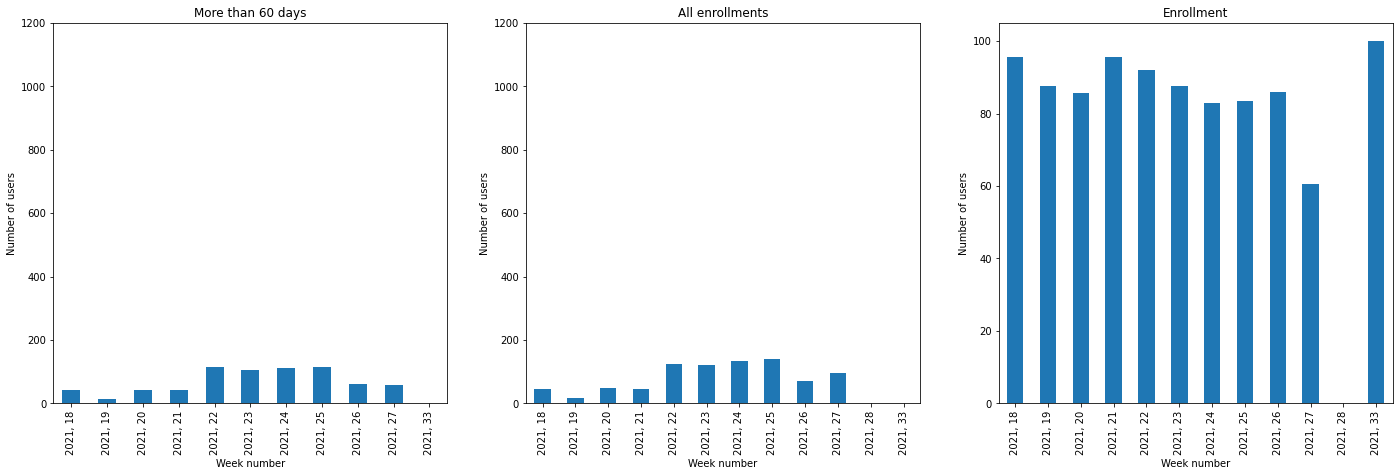

In [27]:
participants_df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .get()

participants_df['START_DATE'].fillna(participants_df['ENROLED_ON'])
participants_df['DAYS'] = participants_df['LAST_DONATION'] - participants_df['START_DATE']

print(f'All: {participants_df.shape[0]}')
print(f'No donations: {participants_df[pd.isnull(participants_df["LAST_DONATION"])].shape[0]}')

participants_df = participants_df[(~pd.isnull(participants_df["LAST_DONATION"])) &
        (participants_df["STATUS"] != "withdrawn") &
        (~pd.isnull(participants_df["DAYS"]))]
participants_df['DAYS'] = participants_df['DAYS'].dt.days

ranges = [0,10,30,60,90,180,300]
df = pd.cut(participants_df['DAYS'], ranges).value_counts().sort_index().to_frame()
df.columns = ['count']

def to_week_group(df, date_column):
    result = df.loc[~pd.isnull(df[date_column])][['ALP_ID', date_column]].copy()
    result['week'] = result[date_column].apply(lambda x: to_week_number(x))
    week_groups = result.groupby(by=['week'])['ALP_ID'].count()
    return week_groups
    
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,7))
df1 = participants_df[participants_df['DAYS'] > 60]

wg1 = to_week_group(df1, 'START_DATE')
wg1.plot(kind='bar',legend=None, title='More than 60 days', \
                 ax=ax1, ylabel='Number of users', xlabel='Week number');
ax1.set_ylim([0, 1200])

df2 = participants_df[participants_df['START_DATE'] < datetime(2021,10,4)]
wg2 = to_week_group(df2, 'START_DATE')
wg2.plot(kind='bar',legend=None, title='All enrollments', \
                 ax=ax2, ylabel='Number of users', xlabel='Week number');
ax2.set_ylim([0, 1200])

(100*wg1/wg2).plot(kind='bar',legend=None, title='Enrollment', \
                 ax=ax3, ylabel='Number of users', xlabel='Week number');



In [28]:
participants_df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .add_all_submissions() \
    .add_last_donation() \
    .get()

p_df = participants_df[participants_df['CHANNEL'] == 'public_event']
r_df = responses_df[responses_df['ALP_ID'].isin(p_df['ALP_ID'].unique())]
ag = AnalyzeGoals(study, p_df, r_df)
Display.header('OKRs analysis - contribution of public event', 'h2')
ag.print_title('Number of participants', f'{p_df.shape[0]}')
ag.prin_test_criteria()
ag.prin_time_criteria()
ag.print_okr_criteria()
        

p_df = participants_df[participants_df['CHANNEL'] != 'public_event']
r_df = responses_df[responses_df['ALP_ID'].isin(p_df['ALP_ID'].unique())]
ag = AnalyzeGoals(study, p_df, r_df)
Display.header('OKRs analysis - contribution of none public event', 'h2')
ag.print_title('Number of participants', f'{p_df.shape[0]}')
ag.prin_test_criteria()
ag.prin_time_criteria()
ag.print_okr_criteria()

Number of participants:                            2846


Number of tests:                                   8410
Number of users reporting tests:                   1870
Number of users reporting at least 2 tests:        1344
Percentage from 2846 users:                        47.2%


Enrolled before 12.01.2022 (>=8 weeks):            1
Participating 56 days or more:                     0
Percentage from 1 users:                           0.0%


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Users tested >=2 and enrolled after 12.01.2022:    0
Users fulfilling at least one criteria:            0
Percentage from 2846 users:                        0.0%


Number of participants:                            6094


Number of tests:                                   17586
Number of users reporting tests:                   3000
Number of users reporting at least 2 tests:        1795
Percentage from 6094 users:                        29.5%


Enrolled before 11.01.2022 (>=8 weeks):            1322
Participating 56 days or more:                     776
Percentage from 1322 users:                        58.7%


Users tested >=2 and enrolled after 11.01.2022:    54
Users fulfilling at least one criteria:            830
Percentage from 6094 users:                        13.6%


In [29]:
from ecov_utils import Vaccination, TestManager
import matplotlib.ticker as ticker
from study import EcovStudy

v = Vaccination(original_participants_df, responses_df)
tests = v.get_tests()

pos_tests = tests[tests['RESULT'] == 'test_result_pos']
count_all_users = original_participants_df.shape[0]

Display.header('COVID-19 test', 'h1')
Display.header('Tests', 'h2')
print(f'{"Number of tests reported:":<40} {tests.shape[0]}')
print(f'{"Number of positive tests:":<40} {pos_tests.shape[0]}')
Display.header('Participants with tests', 'h2')
print(f'{"All participants:":<40} {count_all_users}')
print(f'{"Participants reporting tests:":<40} {len(tests["ALP_ID"].unique())}')

Number of tests reported:                6133
Number of positive tests:                101


All participants:                        8940
Participants reporting tests:            760


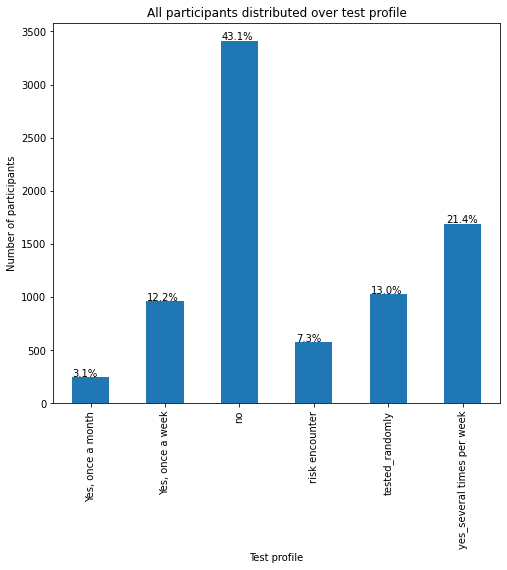

In [13]:
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info', 'regular_testing', 'TEST_PROFILE') \
    .get()

Display.header('Users distributed by their testing behaviour', 'h2')

fig, ax1 = plt.subplots(1,1, figsize=(8,7))
vc = df['TEST_PROFILE'].value_counts().sort_index()
vc.plot(kind="bar", title='All participants distributed over test profile', ax=ax1, ylabel='Number of participants', xlabel='Test profile', legend=None)

for p in ax1.patches:
    value = round(100 * p.get_height()/df[~pd.isnull(df['TEST_PROFILE'])].shape[0],1)
    ax1.annotate(f'{value}%', (p.get_x() * 1.005, p.get_height() * 1.005))

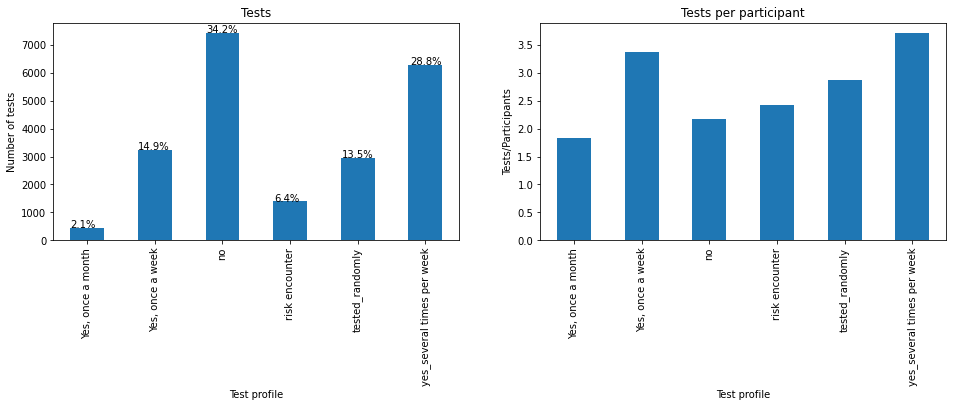

In [14]:
import matplotlib.pyplot as plt

df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info', 'regular_testing', 'TEST_PROFILE') \
    .get()

Display.header('Tests distributed by their participant behaviour', 'h2')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

    
vc1 = tests['TEST_PROFILE'].value_counts().sort_index()
vc1.plot(kind="bar", title='Tests', ax=ax1, ylabel='Number of tests', xlabel='Test profile')

for p in ax1.patches:
    value = round(100 * p.get_height() / tests['TEST_PROFILE'].shape[0],1)
    ax1.annotate(f'{value}%', (p.get_x() * 1.005, p.get_height() * 1.005))
    
vc2 = df['TEST_PROFILE'].value_counts().sort_index()
df = pd.merge(vc1.reset_index(), vc2.reset_index(), how='left', on='index')
df.columns = ['TEST_PROFILE', 'TEST', 'PARTICIPANTS']
df['TESTS_PER_PARTICIPANT'] = df['TEST'] / df['PARTICIPANTS']
df = df.drop(['TEST', 'PARTICIPANTS'], axis=1)
df = df.set_index('TEST_PROFILE')
df.plot(kind="bar", title='Tests per participant', ax=ax2, ylabel='Tests/Participants', xlabel='Test profile', legend=None);

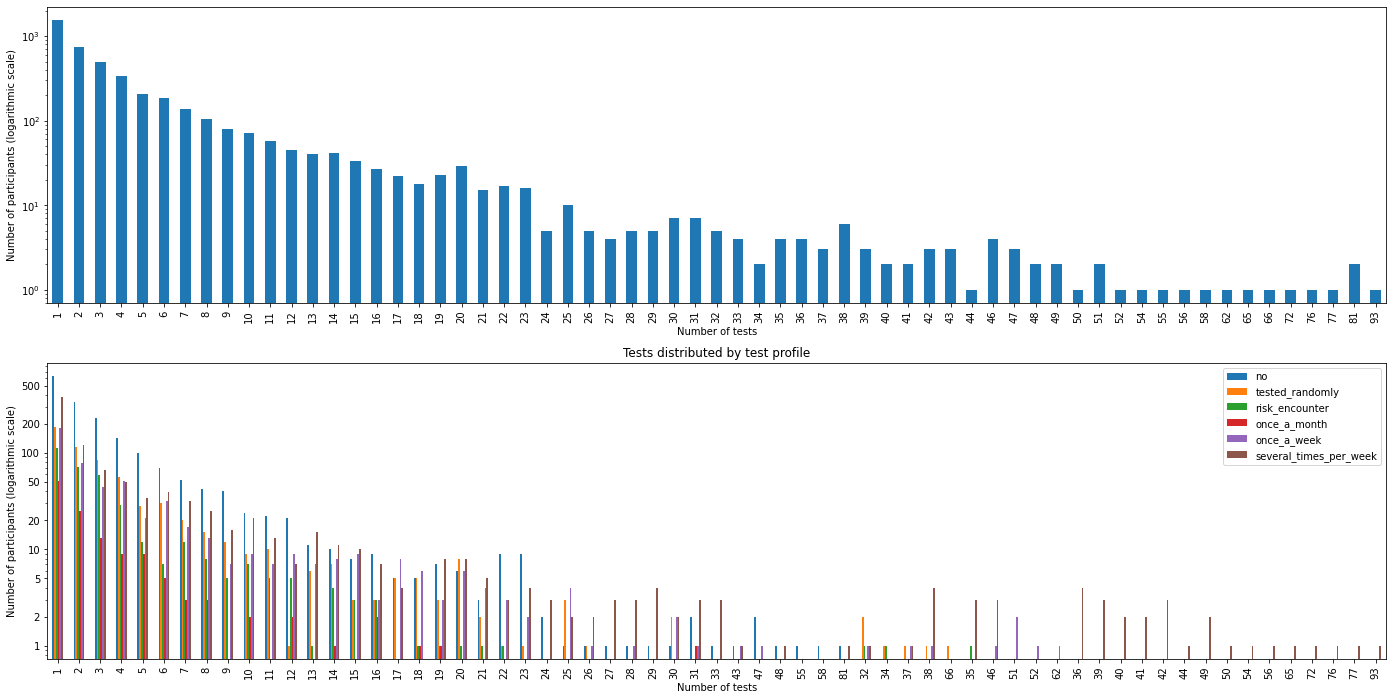

In [15]:
Display.header('Users distributed by number of tests', 'h2')
tests_df = TestManager(responses_df).get()

df = tests_df.groupby('ALP_ID').count().reset_index() 
vc = df['TEST_DATE'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(24,12))

ax1.set_yscale('log')
vc.plot(ax=ax1, kind="bar", 
        ylabel='Number of participants (logarithmic scale)', 
        xlabel='Number of tests');


tests_df = TestManager(responses_df).get()
df = tests_df[['ALP_ID', 'TEST_DATE']].groupby('ALP_ID').count() \
    .reset_index().rename(columns={'TEST_DATE': 'COUNT_TEST'})
participnats_df = ParticipantsBuilder(EcovStudy(), original_participants_df, responses_df) \
    .add_choice('personal_info', 'regular_testing', 'TEST_PROFILE') \
    .get()

df = pd.merge(df, participnats_df, how='left', on='ALP_ID')
df = df.groupby(by=['COUNT_TEST','TEST_PROFILE'])[['ALP_ID']].count().reset_index().rename(columns={'ALP_ID': 'USERS'})

result = df[df['TEST_PROFILE'] == 'no'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'no'})
temp = df[df['TEST_PROFILE'] == 'tested_randomly'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'tested_randomly'})
result = pd.merge(result, temp, how='outer', on='COUNT_TEST')
temp = df[df['TEST_PROFILE'] == 'risk encounter'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'risk_encounter'})
result = pd.merge(result, temp, how='outer', on='COUNT_TEST')
temp = df[df['TEST_PROFILE'] == 'Yes, once a month'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'once_a_month'})
result = pd.merge(result, temp, how='outer', on='COUNT_TEST')
temp = df[df['TEST_PROFILE'] == 'Yes, once a week'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'once_a_week'})
result = pd.merge(result, temp, how='outer', on='COUNT_TEST')
temp = df[df['TEST_PROFILE'] == 'yes_several times per week'][['COUNT_TEST', 'USERS']].rename(columns={'USERS': 'several_times_per_week'})
result = pd.merge(result, temp, how='outer', on='COUNT_TEST')
result = result.fillna(0).set_index('COUNT_TEST')

ax2.set_yscale('log')
ax2.set_yticks([1, 2, 5, 10, 20, 50, 100, 200, 500])
ax2.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
result.plot(kind="bar", ax=ax2, title='Tests distributed by test profile',
            ylabel='Number of participants (logarithmic scale)', 
            xlabel='Number of tests');

Participating longer than 8 week: 2017
Participating longer than 8 week without tests: 253 (13%)


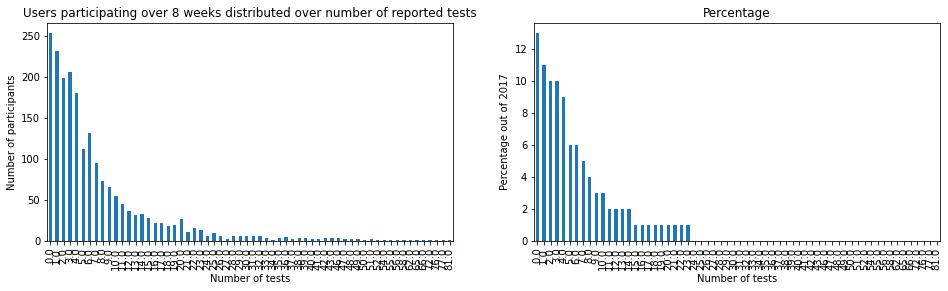

In [16]:
import matplotlib.pyplot as plt

participants_df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .get()
    
tests = TestManager(responses_df).get()
tested_participants = tests.groupby(by=['ALP_ID'])['TEST_DATE'].count() \
    .reset_index().rename(columns={'TEST_DATE': 'COUNT_TESTS'})

participants_df['TIME_IN_STUDY'] = (participants_df['LAST_DONATION'] - participants_df['ENROLED_ON']).dt.days
df = participants_df[participants_df['TIME_IN_STUDY'] >= 8 * 7]
df = df[df['STATUS'] == 'enrolled']
    
df = pd.merge(df, tested_participants, how='left', on='ALP_ID').fillna(0)
vc = df['COUNT_TESTS'].value_counts().sort_index()

Display.header('Tests reported by long time participants', 'h2')
print(f'Participating longer than 8 week: {df.shape[0]}')
print(f'Participating longer than 8 week without tests: {vc[0]} ({round(100 * vc[0]/df.shape[0])}%)')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
vc.plot(kind="bar", ax=ax1, title='Users participating over 8 weeks distributed over number of reported tests',
        ylabel='Number of participants', 
        xlabel='Number of tests');

vc = round(100 * vc/df.shape[0])
vc.plot(kind="bar", ax=ax2, title='Percentage',
        ylabel=f'Percentage out of {df.shape[0]}', 
        xlabel='Number of tests');

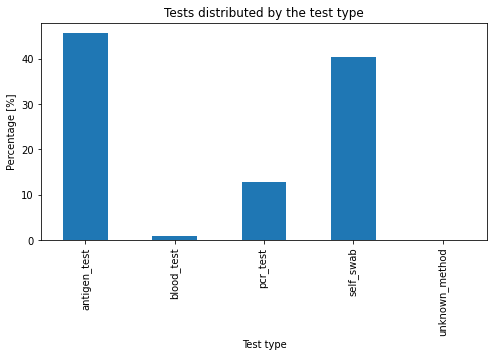

In [17]:
tests = TestManager(responses_df).get()
vc = tests['METHOD'].value_counts().sort_index()
vc = round(100 * vc / tests.shape[0], 1)

Display.header('Tests types', 'h2')
vc.plot(kind="bar", legend=None, title='Tests distributed by the test type', 
        xlabel='Test type', ylabel='Percentage [%]', figsize=(8,4));

In [18]:
from ecov_utils import Vaccination
    
v = Vaccination(original_participants_df, responses_df)

tests = v.get_tests()
Display.frame(tests,3)

pos_tests = tests[tests['RESULT'] == 'test_result_pos']
count_all_users = original_participants_df.shape[0]

Display.header('COVID-19 test', 'h2')
Display.header('Tests', 'h3')
print(f'{"Number of tests reported:":<40} {tests.shape[0]}')
print(f'{"Number of positive tests:":<40} {pos_tests.shape[0]}')
Display.header('Participants', 'h3')
print(f'{"All participants:":<40} {count_all_users}')
print(f'{"Participants reporting tests:":<40} {len(tests["ALP_ID"].unique())}')

Display.header('Test criteria', 'h3')
tm = TestManager(responses_df)

MIN_2_TESTS = 2
participants_with_tests = tm.count_participants(MIN_2_TESTS)
title = f'Reporting {MIN_2_TESTS} and more tests:'
print(f'{title:<40} {participants_with_tests}')
percent = round(100 * participants_with_tests / count_all_users, 1)
title = f'Percentage from {count_all_users} users:'
print(f'{title:<40} {percent}%')

print('-' * 46)

MIN_6_TESTS = 6
participants_with_tests = tm.count_participants(MIN_6_TESTS)
title = f'Reporting {MIN_6_TESTS} and more tests:'
print(f'{title:<40} {participants_with_tests}')
percent = round(100 * participants_with_tests / count_all_users, 1)
title = f'Percentage from {count_all_users} users:'
print(f'{title:<40} {percent}%')

Display.header('Vaccinated vs unvaccinated', 'h3')

s1 = tests['VACCINE_STATUS'].value_counts().rename('ALL_TESTS')
s2 = pos_tests['VACCINE_STATUS'].value_counts().rename('POS_TESTS')
s3 = round(100 * s2/s1, 2).rename('POS/ALL [%]')
df = pd.concat([s1, s2, s3], axis=1)

Display.frame(df)

,ALP_ID,TEST_DATE,AUTHORED,QUESTIONNAIRE,METHOD,RESULT,TEST_PROFILE,VACCINE_STATUS,VACCINE_TYPE
3131,1844,2019-08-01,2019-08-01,corona_testing,self_swab,test_result_neg,"Yes, once a month",NOT-VACCNIATED,NaN
3851,2072,2020-03-16,2020-03-16,corona_testing,pcr_test,test_result_neg,no,NOT-VACCNIATED,NaN
4402,2284,2020-03-24,2020-03-24,corona_testing,pcr_test,test_result_pos,"Yes, once a week",NOT-VACCNIATED,NaN


Number of tests reported:                21710
Number of positive tests:                1073


All participants:                        8258
Participants reporting tests:            4412


Reporting 2 and more tests:              2870
Percentage from 8258 users:              34.8%
----------------------------------------------
Reporting 6 and more tests:              1078
Percentage from 8258 users:              13.1%


,ALL_TESTS,POS_TESTS,POS/ALL [%]
FULLY,15342,761,4.96
NOT-VACCNIATED,4635,273,5.89
PARTIALLY,1583,38,2.40
UNKNOWN,150,1,0.67


all users: 8258
users reporting 1st vaccine date after the second vaccine date: 29 (0.4%)
users reporting the same date for 1st and 2nd vaccines: 74 (0.9%)
users reporting 2nd vaccine lass than 21 days afte the first: 235 (2.8%)


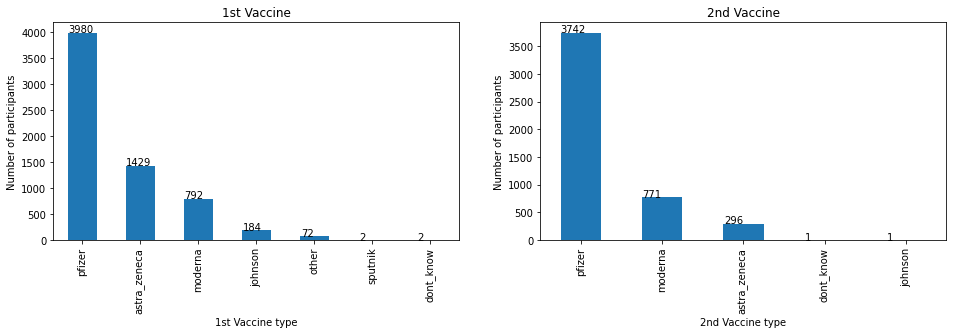

In [19]:
from study import EcovStudy, ParticipantsBuilder

df = ParticipantsBuilder(EcovStudy(), original_participants_df, responses_df) \
    .add_choice('covid_first_vaccine', 'corona_vaccination_received', '1ST_DOSE') \
    .add_choice('covid_first_vaccine', 'which_vaccine_received', '1ST_VACCINE_TYPE') \
    .add_answer('covid_first_vaccine', 'when_vaccinated_first_time', '1ST_VACCINE_DATE') \
    .add_choice('covid_second_vaccine','has_received_second_vacciation', '2ND_DOSE') \
    .add_choice('covid_second_vaccine', 'which_vaccine_received', '2ND_VACCINE_TYPE') \
    .add_answer('covid_second_vaccine', 'when_vaccinated_second_time', '2ND_VACCINE_DATE') \
    .add_choice('personal_info','country_of_residence', 'COUNTRY') \
    .add_last_donation() \
    .get()

df['1ST_VACCINE_DATE'] = pd.to_datetime(df['1ST_VACCINE_DATE'], format='%Y-%m-%d', errors='coerce')
df['2ND_VACCINE_DATE'] = pd.to_datetime(df['2ND_VACCINE_DATE'], format='%Y-%m-%d', errors='coerce')

Display.header('Vaccination', 'h1')

Display.header('Vaccination type', 'h2')
count_all = df['ALP_ID'].count()
print(f'all users: {count_all}')

temp = df[df['1ST_VACCINE_DATE'] > df['2ND_VACCINE_DATE']]
print(f'users reporting 1st vaccine date after the second vaccine date: {temp["ALP_ID"].count()} ({round(100 * temp["ALP_ID"].count() / count_all, 1)}%)')
temp = df[df['1ST_VACCINE_DATE'] == df['2ND_VACCINE_DATE']]
print(f'users reporting the same date for 1st and 2nd vaccines: {temp["ALP_ID"].count()} ({round(100 * temp["ALP_ID"].count() / count_all, 1)}%)')
temp = df[df['1ST_VACCINE_DATE'] + timedelta(days=21) > df['2ND_VACCINE_DATE']]
print(f'users reporting 2nd vaccine lass than 21 days afte the first: {temp["ALP_ID"].count()} ({round(100 * temp["ALP_ID"].count() / count_all, 1)}%)')
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
vc = df['1ST_VACCINE_TYPE'].value_counts()
vc.plot(kind="bar", title='1st Vaccine', ax=ax1, ylabel='Number of participants', xlabel='1st Vaccine type', legend=None);
Display.tag_bars(ax1)

vc = df['2ND_VACCINE_TYPE'].value_counts()
vc.plot(kind="bar", title='2nd Vaccine', ax=ax2, ylabel='Number of participants', xlabel='2nd Vaccine type', legend=None);
Display.tag_bars(ax2)

Comparing vaccine status on 13.05.2021 with the status today


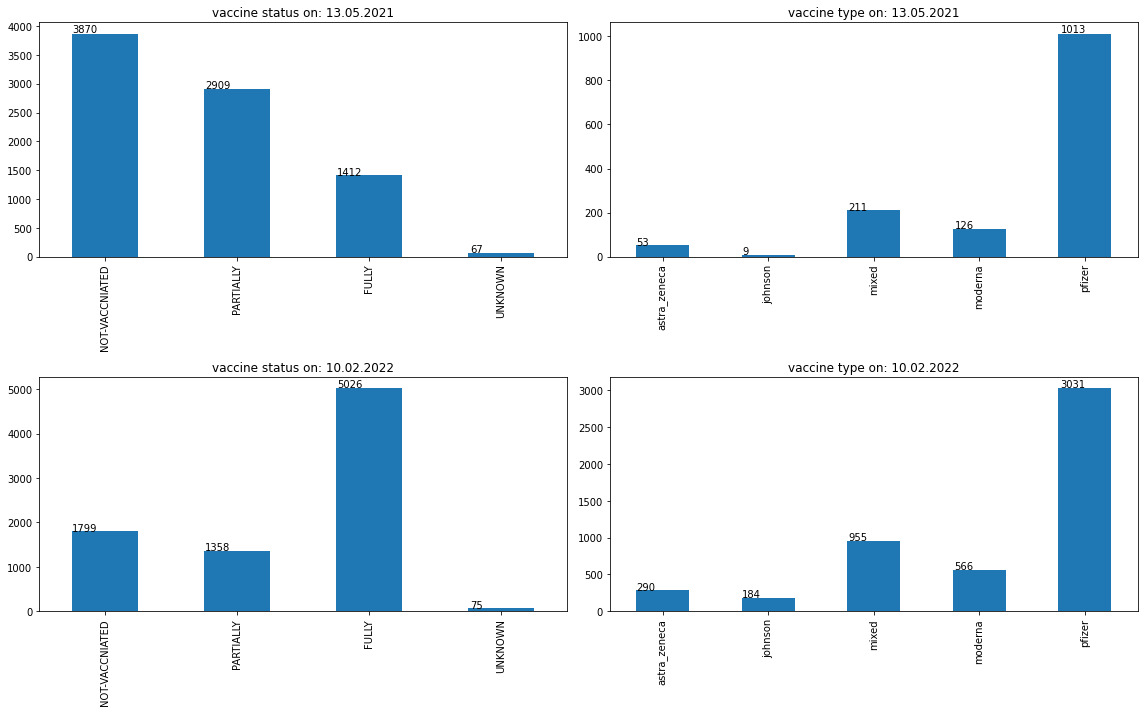

In [20]:
import matplotlib.pyplot as plt
from ecov_utils import Vaccination 
from datetime import datetime

v = Vaccination(original_participants_df, responses_df)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,10))

day = datetime(2021, 5, 13, 0, 0)
Display.header('Vaccination status', 'h2')
print(f'Comparing vaccine status on {day.strftime("%d.%m.%Y")} with the status today')
      
df = v.get_vaccine_status(day)
value_cnts = df['status'].value_counts()[['NOT-VACCNIATED', 'PARTIALLY', 'FULLY', 'UNKNOWN']]
value_cnts.plot(kind='bar', ax=ax1, title=f'vaccine status on: {day.strftime("%d.%m.%Y")}')
value_cnts = df['type'].value_counts().sort_index()
value_cnts.plot(kind='bar', ax=ax2, title=f'vaccine type on: {day.strftime("%d.%m.%Y")}')

day = datetime.now()
df = v.get_vaccine_status(day)
value_cnts = df['status'].value_counts()[['NOT-VACCNIATED', 'PARTIALLY', 'FULLY', 'UNKNOWN']]
value_cnts.plot(kind='bar', ax=ax3, title=f'vaccine status on: {day.strftime("%d.%m.%Y")}')
value_cnts = df['type'].value_counts().sort_index()
value_cnts.plot(kind='bar', ax=ax4, title=f'vaccine type on: {day.strftime("%d.%m.%Y")}')

for ax in [ax1, ax2, ax3, ax4]:
    Display.tag_bars(ax)
    
fig.tight_layout()

Number of symptoms reported:             8383
Number of all participants:              8258
Number of users reporting symptoms:      1511 (18.3%)
Participants from public event:          284
Participants not from public event:      1227


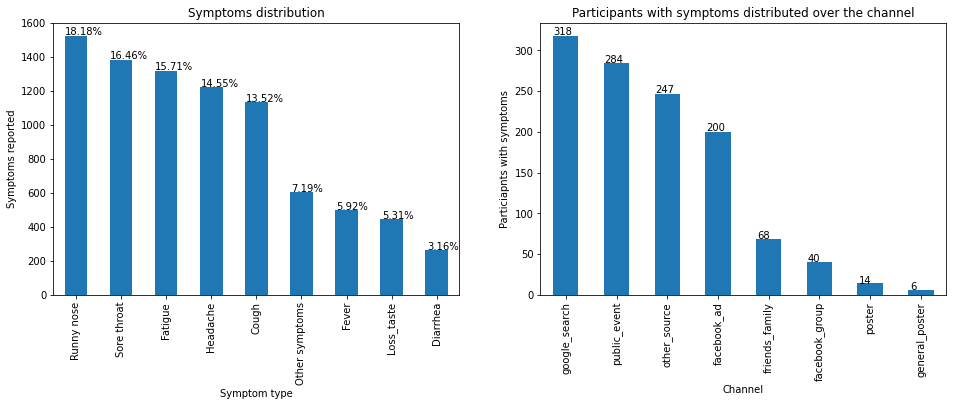

In [21]:
from ecov_utils import Vaccination 
from datetime import datetime, timedelta

rb = ResponsesBuilder(responses_df)
df = rb.get_choice('SYMPTOMS', 'which_new_symptoms')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

vc = df['SYMPTOMS'].value_counts()
vc.plot(kind="bar", title='Symptoms distribution', ax=ax1,
        xlabel='Symptom type', ylabel='Symptoms reported');
Display.tag_bars(ax1,  df.shape[0])

Display.header('Symptoms', 'h1')
print(f'{"Number of symptoms reported:":<40} {df.shape[0]}')

participants_df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .get()
s = df.groupby("ALP_ID").agg({"SYMPTOMS": "nunique"}).reset_index()
participants_df = pd.merge(s, participants_df, how='left', on='ALP_ID')
vc = participants_df['CHANNEL'].value_counts()
vc.plot(kind="bar", title='Participants with symptoms distributed over the channel', ax=ax2,
        xlabel='Channel', ylabel='Particiapnts with symptoms');
Display.tag_bars(ax2)

print(f'{"Number of all participants:":<40} {original_participants_df.shape[0]}')
percent = round(100 * participants_df.shape[0] / original_participants_df.shape[0], 1)
print(f'{"Number of users reporting symptoms:":<40} {participants_df.shape[0]} ({percent}%)')

df = participants_df[participants_df['CHANNEL'] == 'public_event']
print(f'{"Participants from public event:":<40} {df.shape[0]}')
df = participants_df[participants_df['CHANNEL'] != 'public_event']
print(f'{"Participants not from public event:":<40} {df.shape[0]}')


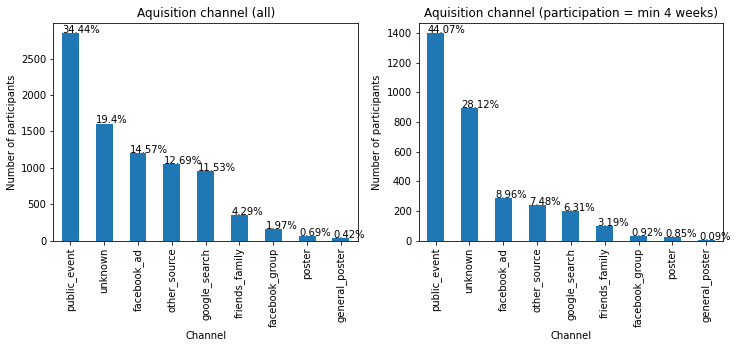

In [22]:
Display.header('Time in the study', 'h1')
Display.header('Acquisition channels', 'h2')

df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .add_last_donation() \
    .get()

df.at[pd.isnull(df['CHANNEL']), 'CHANNEL'] = 'unknown'

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

value_counts = df['CHANNEL'].value_counts()
value_counts.plot(kind="bar", title='Aquisition channel (all)', ylabel='Number of participants', xlabel='Channel', ax=ax1)
Display.tag_bars(ax1,  df['CHANNEL'].shape[0])

df['TIME_DAYS'] = (df['END_DATE'] - df['START_DATE']).dt.days
df['TIME_DAYS'].fillna((df['LAST_DONATION'] - df['ENROLED_ON']).dt.days, inplace=True)
df = df[df['TIME_DAYS'] > 4*7]

value_counts = df['CHANNEL'].value_counts()
value_counts.plot(kind="bar", title='Aquisition channel (participation = min 4 weeks)', ylabel='Number of participants', xlabel='Channel', ax=ax2)
Display.tag_bars(ax2,  df['CHANNEL'].shape[0])

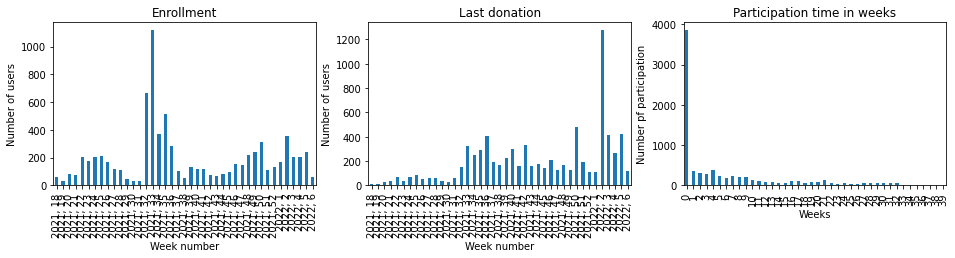

In [23]:

df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .get()

df['TIME_DAYS'] = (df['END_DATE'] - df['START_DATE']).dt.days
df['TIME_DAYS'].fillna((df['LAST_DONATION'] - df['ENROLED_ON']).dt.days, inplace=True)
df = df[~pd.isnull(df['TIME_DAYS'])]

df['TIME_DAYS'] = df['TIME_DAYS'].astype(int)
df['TIME_WEEKS'] = (df['TIME_DAYS']/7).astype(int)

vc = df['TIME_WEEKS'].value_counts().sort_index()

Display.header('All participants', 'h2')
Display.text(f'Current week: {to_week_number(datetime.now())}')

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,3))

plot_over_weeks(df, 'ENROLED_ON', ax1, 'Enrollment', 'Number of users', 'Week number')
plot_over_weeks(df, 'LAST_DONATION', ax2, 'Last donation', 'Number of users', 'Week number')

# vc = vc.drop(index=[0])
vc.plot(kind="bar", ax=ax3, title='Participation time in weeks', 
        xlabel='Weeks', ylabel='Number pf participation');

threshold = responses_df['AUTHORED'].max() - timedelta(days=6*7)
title = f'Number of participants that did no donate anything since {threshold.strftime("%d.%m.%Y")}'
Display.text(f'{title}: {df[df["LAST_DONATION"] < threshold].shape[0]}')

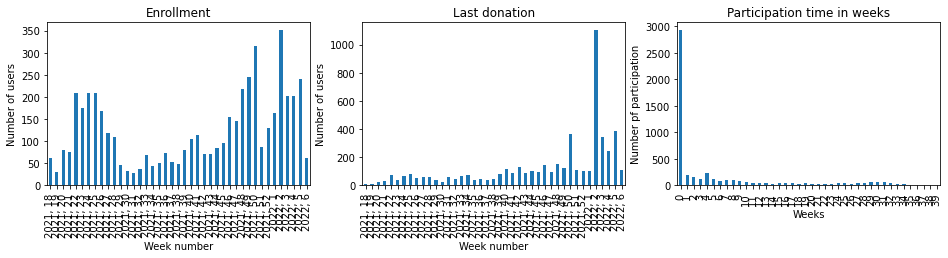

In [24]:
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .add_last_donation() \
    .get()

df = df[df['CHANNEL'] != 'public_event']

df['START_DATE'].fillna(df['ENROLED_ON'], inplace=True)
df['TIME_DAYS'] = (df['END_DATE'] - df['START_DATE']).dt.days
df['TIME_DAYS'].fillna((df['LAST_DONATION'] - df['START_DATE']).dt.days, inplace=True)
df = df[~pd.isnull(df['TIME_DAYS'])]

df['TIME_DAYS'] = df['TIME_DAYS'].astype(int)
df['TIME_WEEKS'] = (df['TIME_DAYS']/7).astype(int)

vc = df['TIME_WEEKS'].value_counts().sort_index()

Display.header('Not including public event', 'h2')
Display.text(f'Current week: {to_week_number(datetime.now())}')

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,3))

plot_over_weeks(df, 'ENROLED_ON', ax1, 'Enrollment', 'Number of users', 'Week number')
plot_over_weeks(df, 'LAST_DONATION', ax2, 'Last donation', 'Number of users', 'Week number')

# vc = vc.drop(index=[0])
vc.plot(kind="bar", ax=ax3, title='Participation time in weeks', 
        xlabel='Weeks', ylabel='Number pf participation');

result = ((responses_df['AUTHORED'].max() - df['START_DATE']).dt.days/7) \
    .astype(int).value_counts().sort_index().to_frame()
Display.text(f'Participants enrolled at least 8 week: {result[result.index >= 8]["START_DATE"].sum()}')
Display.text(f'Participants who were active longer than 8 weeks: {df[df["TIME_DAYS"]>56].shape[0]}')

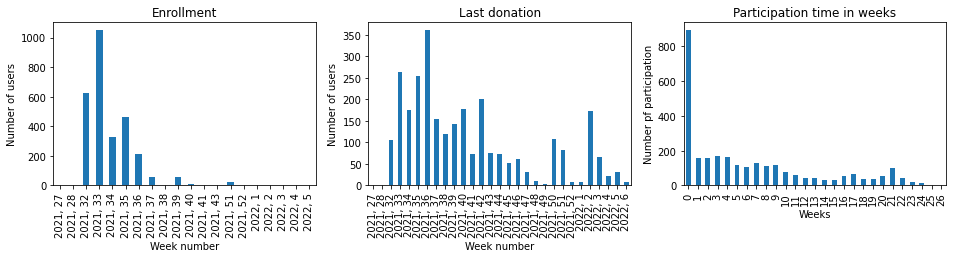

In [25]:
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .add_last_donation() \
    .get()

df = df[df['CHANNEL'] == 'public_event']

df['START_DATE'].fillna(df['ENROLED_ON'], inplace=True)
df['TIME_DAYS'] = (df['END_DATE'] - df['START_DATE']).dt.days
df['TIME_DAYS'].fillna((df['LAST_DONATION'] - df['START_DATE']).dt.days, inplace=True)
df = df[~pd.isnull(df['TIME_DAYS'])]

df['TIME_DAYS'] = df['TIME_DAYS'].astype(int)
df['TIME_WEEKS'] = (df['TIME_DAYS']/7).astype(int)

vc = df['TIME_WEEKS'].value_counts().sort_index()

Display.header('Public event', 'h2')
Display.text(f'Number of participants: {df.shape[0]}')
Display.text(f'Current week: {to_week_number(datetime.now())}')

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,3))

plot_over_weeks(df, 'ENROLED_ON', ax1, 'Enrollment', 'Number of users', 'Week number')
plot_over_weeks(df, 'LAST_DONATION', ax2, 'Last donation', 'Number of users', 'Week number')

# vc = vc.drop(index=[0])
vc.plot(kind="bar", ax=ax3, title='Participation time in weeks', 
        xlabel='Weeks', ylabel='Number pf participation');

result = ((responses_df['AUTHORED'].max() - df['START_DATE']).dt.days/7) \
    .astype(int).value_counts().sort_index().to_frame()
Display.text(f'Participants enrolled at least 8 week: {result[result.index >= 8]["START_DATE"].sum()}')
Display.text(f'Participants who were active longer than 8 weeks: {df[df["TIME_DAYS"]>56].shape[0]}')

1. enrolled:    Still active
2. suspended:   Left the study but did not revoke consent
3. withdrawn:   Left the study and deleted all data
Feedback was given by 260 participants


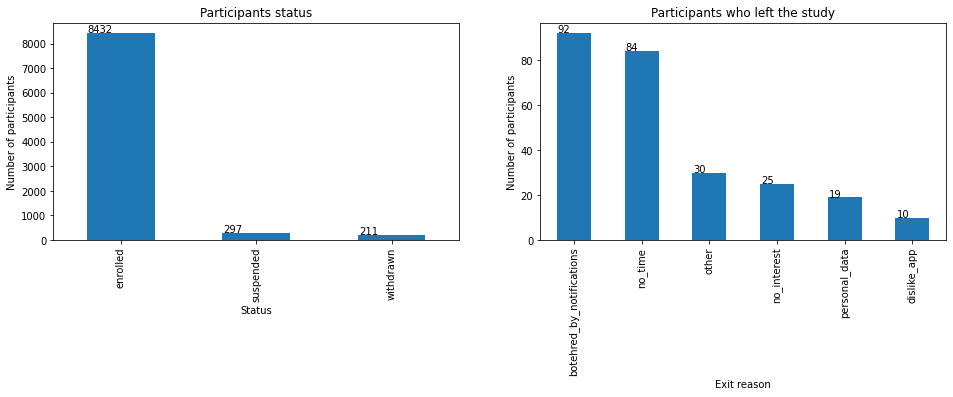

In [20]:
# responses_df['QUESTIONNAIRE'].unique()
study = EcovStudy()

df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .add_choice('E1_exit_interview','exit_reason', 'EXIT_REASON') \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .get()

df['TIME_IN_STUDY'] = df['LAST_DONATION'] - df['ENROLED_ON']
df = df[~df['EXIT_REASON'].isnull()]

Display.header('Why do participants leave the study?', 'h2')
print(f'{"1. enrolled:":<15} Still active')
print(f'{"2. suspended:":<15} Left the study but did not revoke consent')
print(f'{"3. withdrawn:":<15} Left the study and deleted all data')
print(f'Feedback was given by {df.shape[0]} participants')
# Display.frame(df, 5)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

vc = original_participants_df['STATUS'].value_counts()
vc.plot(kind="bar", title='Participants status', ax=ax1,
        ylabel='Number of participants', xlabel='Status');
Display.tag_bars(ax1)

vc = df['EXIT_REASON'].value_counts()
vc.plot(kind="bar", title='Participants who left the study', ax=ax2,
        ylabel='Number of participants', xlabel='Exit reason');
Display.tag_bars(ax2)

In [23]:
study = EcovStudy()
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .add_choice('E1_exit_interview','exit_reason', 'EXIT_REASON') \
    .add_answer('E1_exit_interview','additional_reason', 'REASON') \
    .get()

# df = df[df['EXIT_REASON'] == 'botehred_by_notifications']
df = df[~pd.isnull(df['REASON'])]
Display.header('What reasons do participants write us?', 'h2')
Display.frame(df, 5)

,Unnamed: 0,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,LAST_DONATION,EXIT_REASON,REASON
133,134,5614,NaN,suspended,2021-09-02,2021-11-18,2021-09-02,2021-11-18,other,Grund (Veranstaltung) ausreichend lange her
508,509,3641,NaN,suspended,2021-08-14,2021-10-31,2021-08-14,2021-10-31,other,Ich sehe keinen Sinn mehr darin noch Monate nach der Teilnahme an dem Festival Medimeisterschaften an dieser Studie teilzunehmen.
623,624,4416,NaN,suspended,2021-08-20,2021-10-06,2021-08-20,2021-10-06,other,"The Study was Part of a Hygiene Concept of a Festival, which i visited and was one month ago."
626,627,6023,NaN,suspended,2021-09-09,2021-10-06,2021-09-09,2021-10-06,other,Ich lass mich weder Impfen noch Testen darum kann Ich auf die zwei Fragen nicht Antworten
921,922,6940,NaN,suspended,2021-10-11,2021-11-10,2021-10-11,2021-11-10,other,Keine TeilnahmebestÃ¤tigung


In [13]:
from datetime import date
from utils import get_age_group

study = EcovStudy()
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .add_choice('E1_exit_interview','exit_reason', 'EXIT_REASON') \
    .add_answer('E1_exit_interview','additional_reason', 'REASON') \
    .add_choice('personal_info','participant_gender', 'GENDER') \
    .add_choice('personal_info','regular_testing', 'REGULAR_TESTED') \
    .add_choice('personal_info','country_of_residence', 'COUNTRY') \
    .add_answer('personal_info','participant_year_born', 'BIRTH_YEAR') \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .get()

df['TIME_IN_STUDY'] = df['LAST_DONATION'] - df['ENROLED_ON']
df["BIRTH_YEAR"] = df["BIRTH_YEAR"].fillna(0).astype(int)
df['AGE_GROUP'] = df.apply(lambda row : get_age_group(row['BIRTH_YEAR']), axis = 1)

columns = ['ALP_ID', 'REASON', 'GENDER', 'REGULAR_TESTED', 'COUNTRY', 'AGE_GROUP', 'CHANNEL']
df = df[~df['REASON'].isnull()][columns]

Display.header('What reasons do participants write us?', 'h2')

class Vaccination2:
    def __init__(self, participants_df, responses_df):
        self.df = self._build_frame(participants_df, responses_df)

    def _build_frame(self, participants_df, responses_df):
        df = ParticipantsBuilder(EcovStudy(), participants_df, responses_df) \
        .add_choice('covid_first_vaccine', 'corona_vaccination_received', '1ST_DOSE') \
        .add_choice('covid_first_vaccine', 'which_vaccine_received', '1ST_VACCINE_TYPE') \
        .add_answer('covid_first_vaccine', 'when_vaccinated_first_time', '1ST_VACCINE_DATE') \
        .add_choice('covid_second_vaccine','has_received_second_vacciation', '2ND_DOSE') \
        .add_choice('covid_second_vaccine', 'which_vaccine_received', '2ND_VACCINE_TYPE') \
        .add_answer('covid_second_vaccine', 'when_vaccinated_second_time', '2ND_VACCINE_DATE') \
        .add_last_donation() \
        .get()

        df['1ST_VACCINE_DATE'] = pd.to_datetime(df['1ST_VACCINE_DATE'], format='%Y-%m-%d', errors='coerce')
        df['2ND_VACCINE_DATE'] = pd.to_datetime(df['2ND_VACCINE_DATE'], format='%Y-%m-%d', errors='coerce')
        return df
        
    def get_frame(self):
        return self.df
    
    def get_tests(self):
        return self.tests
    
    def get_vaccine_status(self, day):
        return pd.DataFrame(data={
            'ALP_ID': self.df.apply(lambda row : row['ALP_ID'], axis=1),
            'status': self.df.apply(lambda row : self._vaccine_status_on_date(day, row), axis=1)
        })

    def _vaccine_status_on_date(self, date, row):
        if pd.isnull(date): return 'UNKNOWN'
        dose1_occured = row['1ST_DOSE']
        dose1_date = row['1ST_VACCINE_DATE']
        dose1_type = row['1ST_VACCINE_TYPE']
        dose2_occured = row['2ND_DOSE']
        dose2_date = row['2ND_VACCINE_DATE']
        dose2_type = row['2ND_VACCINE_TYPE'] 

        if ((dose1_occured == 'yes') & pd.isna(dose1_date)) | ((dose2_occured == 'yes') & pd.isna(dose2_date)):
            return 'UNKNOWN'

        if (dose1_occured != 'yes') or (date < dose1_date):
            return 'NOT-VACCNIATED'

        if (dose2_occured == 'yes') & (date >= dose2_date):
            return 'FULLY'

        if dose1_type in ['johnson']: return 'FULLY' 
        if dose1_type in ['pfizer', 'moderna', 'astra_zeneca', 'sputnik']: return 'PARTIALLY' 
        return 'UNKNOWN'
    
v = Vaccination2(original_participants_df, responses_df)
temp = v.get_vaccine_status(datetime.now())

pd.set_option("max_colwidth", 100)
df = pd.merge(df, temp, how='left', on='ALP_ID')
Display.frame(df)
pd.set_option("max_colwidth", 50)


,ALP_ID,REASON,GENDER,REGULAR_TESTED,COUNTRY,AGE_GROUP,CHANNEL,status
0,5614,Grund (Veranstaltung) ausreichend lange her,gender_male,"Yes, once a month",DE,20-30,public_event,FULLY
1,3641,Ich sehe keinen Sinn mehr darin noch Monate nach der Teilnahme an dem Festival Medimeisterschaften an dieser Studie teilzunehmen.,gender_female,"Yes, once a week",DE,20-30,public_event,FULLY
2,4416,"The Study was Part of a Hygiene Concept of a Festival, which i visited and was one month ago.",gender_male,no,DE,20-30,public_event,FULLY
3,6023,Ich lass mich weder Impfen noch Testen darum kann Ich auf die zwei Fragen nicht Antworten,gender_male,no,AT,>60,friends_family,NOT-VACCNIATED
4,6940,Keine TeilnahmebestÃ¤tigung,gender_male,yes_several times per week,DE,30-40,google_search,NOT-VACCNIATED
5,3656,Medimeisterschaften are over,gender_male,tested_randomly,DE,20-30,public_event,FULLY
6,2885,"Ich bin geimpft, gesund und habe zu der Studie nichts beizutragen",gender_female,"Yes, once a week",DE,40-50,NaN,FULLY
7,3503,Habe nur fÃ¼r die Medis daran teilgenommen und die sind ja jetzt schon lÃ¤nger vorbei,gender_female,risk encounter,DE,20-30,public_event,FULLY
8,2514,Seit vollem Impfschutz kaum mehr Schnelltests oder im Sinne der Studie Berichtenswertes. Danke fÃ¼r Ihre Arbeit und alles Gute!,gender_male,"Yes, once a week",DE,30-40,NaN,FULLY
9,3083,ich bin bereits geimpft.,gender_female,no,DE,>60,facebook_ad,FULLY


In [13]:
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .add_choice('E1_exit_interview','exit_reason', 'EXIT_REASON') \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .get()

def get_exposure_dates():
    dates = []
    instance_date = datetime(2021, 4, 7)
    while instance_date.date() < datetime.now().date():
        dates.append(instance_date)
        instance_date = instance_date + timedelta(days=28)
    dates.append(instance_date)
    return dates

exp_dates = get_exposure_dates()
print(exp_dates)

df['exp'] = None
for i in range(len(exp_dates)):
    index = len(exp_dates) - i - 1
    df.loc[(df['LAST_DONATION'] >= exp_dates[index]) & \
           (pd.isnull(df['exp'])), 'exp'] = exp_dates[index]
    
Display.header('Group participants by last donation date - no public event', 'h2')
print(f'Last donation on: {df["LAST_DONATION"].max()}')
print(f'Number of participants: {df.shape[0]}')
df2 = df[df['CHANNEL'] != 'public_event']
print(df2.shape[0])
vc = df2['exp'].value_counts().sort_index(ascending=False)
Display.frame(vc.to_frame())
    
Display.header('Group participants by last donation date - public event only', 'h2')
df2 = df[df['CHANNEL'] == 'public_event']
print(df2.shape[0])
vc = df2['exp'].value_counts().sort_index(ascending=False)
Display.frame(vc.to_frame())

[datetime.datetime(2021, 4, 7, 0, 0), datetime.datetime(2021, 5, 5, 0, 0), datetime.datetime(2021, 6, 2, 0, 0), datetime.datetime(2021, 6, 30, 0, 0), datetime.datetime(2021, 7, 28, 0, 0), datetime.datetime(2021, 8, 25, 0, 0), datetime.datetime(2021, 9, 22, 0, 0), datetime.datetime(2021, 10, 20, 0, 0), datetime.datetime(2021, 11, 17, 0, 0), datetime.datetime(2021, 12, 15, 0, 0), datetime.datetime(2022, 1, 12, 0, 0), datetime.datetime(2022, 2, 9, 0, 0), datetime.datetime(2022, 3, 9, 0, 0), datetime.datetime(2022, 4, 6, 0, 0)]


Last donation on: 2022-03-09 00:00:00
Number of participants: 8940
6094


,exp
2022-02-09,1928
2022-01-12,1051
2021-12-15,558
2021-11-17,479
2021-10-20,423
2021-09-22,344
2021-08-25,188
2021-07-28,199
2021-06-30,205
2021-06-02,265


2846


,exp
2022-03-09,1
2022-02-09,194
2022-01-12,164
2021-12-15,176
2021-11-17,80
2021-10-20,402
2021-09-22,507
2021-08-25,938
2021-07-28,382
2021-06-30,2


In [28]:
# dates = []
# instance_date = datetime(2021, 4, 7)
# while instance_date.date() < datetime.now().date() + timedelta(days=200):
#     dates.append(instance_date)
#     instance_date = instance_date + timedelta(days=28)
# print(dates)

,ALP_ID,REASON,GENDER,REGULAR_TESTED,COUNTRY,AGE_GROUP,CHANNEL,status
0,5614,Grund (Veranstaltung) ausreichend lange her,gender_male,"Yes, once a month",DE,20-30,public_event,FULLY
1,3641,Ich sehe keinen Sinn mehr darin noch Monate nach der Teilnahme an dem Festival Medimeisterschaften an dieser Studie teilzunehmen.,gender_female,"Yes, once a week",DE,20-30,public_event,FULLY
2,4416,"The Study was Part of a Hygiene Concept of a Festival, which i visited and was one month ago.",gender_male,no,DE,20-30,public_event,FULLY
3,6023,Ich lass mich weder Impfen noch Testen darum kann Ich auf die zwei Fragen nicht Antworten,gender_male,no,AT,>60,friends_family,NOT-VACCNIATED
4,6940,Keine TeilnahmebestÃ¤tigung,gender_male,yes_several times per week,DE,30-40,google_search,NOT-VACCNIATED
5,3656,Medimeisterschaften are over,gender_male,tested_randomly,DE,20-30,public_event,FULLY
6,2885,"Ich bin geimpft, gesund und habe zu der Studie nichts beizutragen",gender_female,"Yes, once a week",DE,40-50,NaN,FULLY
7,3503,Habe nur fÃ¼r die Medis daran teilgenommen und die sind ja jetzt schon lÃ¤nger vorbei,gender_female,risk encounter,DE,20-30,public_event,FULLY
8,2514,Seit vollem Impfschutz kaum mehr Schnelltests oder im Sinne der Studie Berichtenswertes. Danke fÃ¼r Ihre Arbeit und alles Gute!,gender_male,"Yes, once a week",DE,30-40,NaN,FULLY
9,3083,ich bin bereits geimpft.,gender_female,no,DE,>60,facebook_ad,FULLY


In [14]:
# df = ParticipantsBuilder(study, original_participants_df, responses_df) \
#     .add_last_donation() \
#     .add_choice('E1_exit_interview','exit_reason', 'EXIT_REASON') \
#     .add_answer('E1_exit_interview','additional_reason', 'REASON') \
#     .get()

# df['TIME_IN_STUDY'] = df['LAST_DONATION'] - df['ENROLED_ON']
# df = df[~df['REASON'].isnull()].sort_values(by=['LAST_DONATION'], ascending=False)
# Display.frame(df,20)

Number of participants: 5414 (65.6%)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


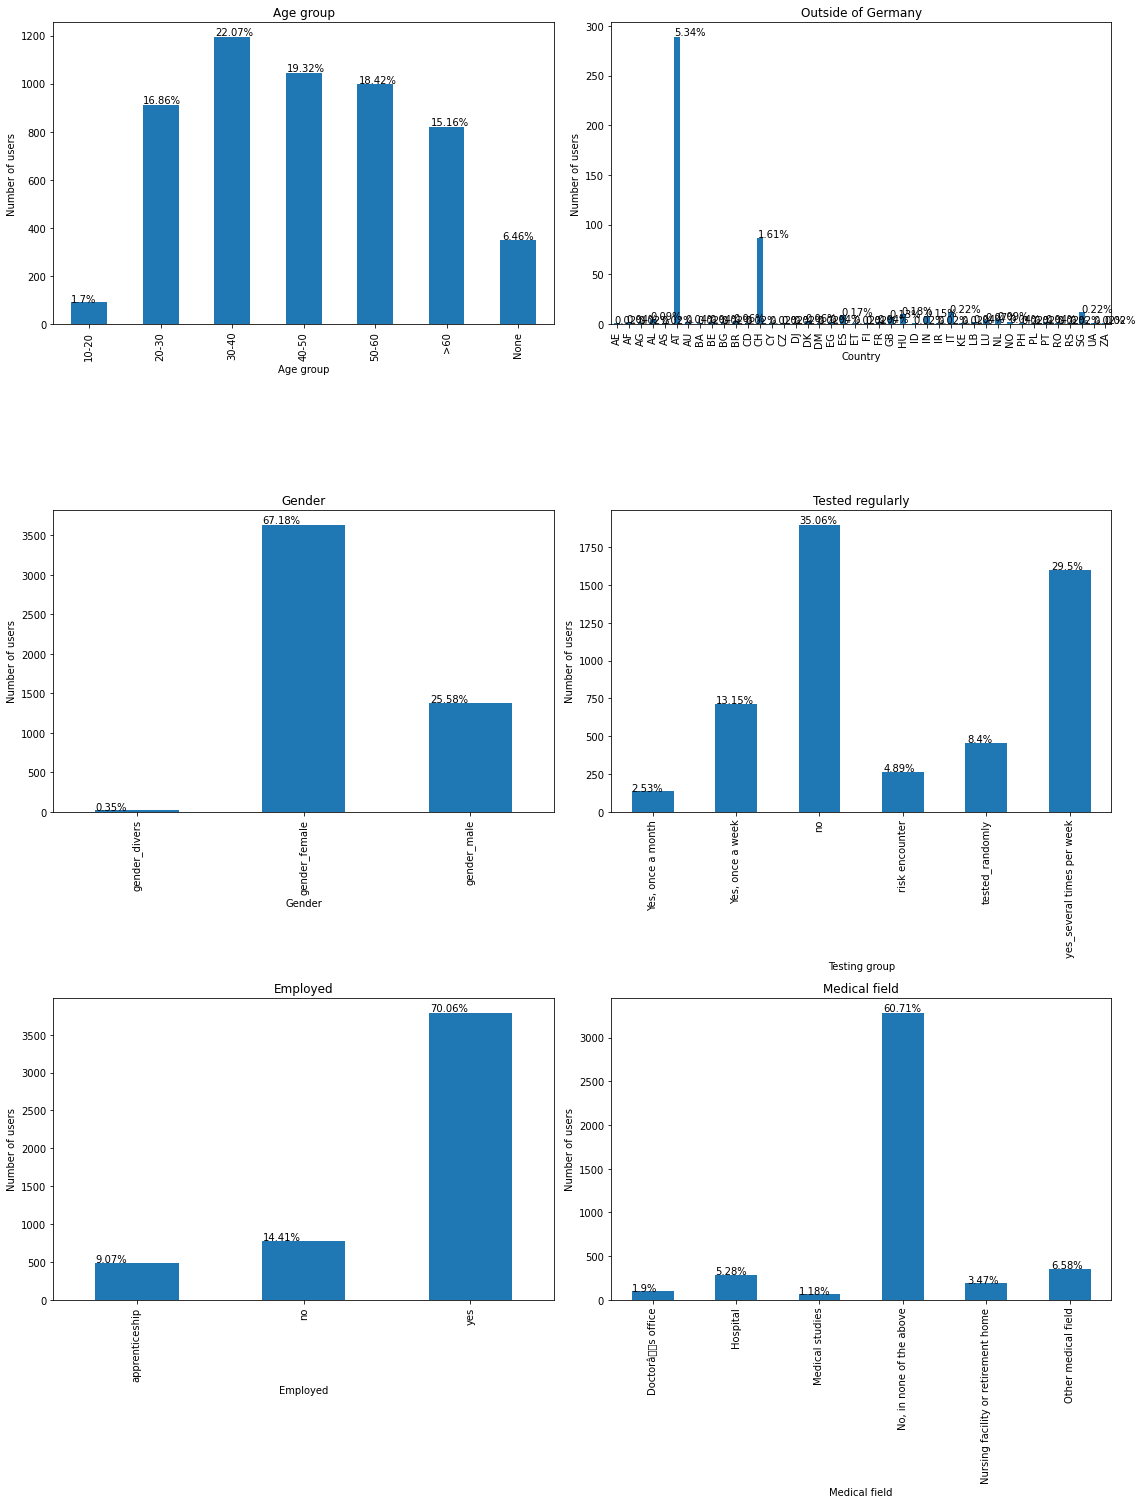

In [30]:
import matplotlib.pyplot as plt
from datetime import date

def bar_distribution(series, ax, title, xlabel, ylabel):
    value_counts = series.value_counts().sort_index()
    value_counts.plot(kind="bar", title=title, ax=ax, ylabel=ylabel, xlabel=xlabel)
    
def draw(result):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(16,21))
    bar_distribution(result['AGE_GROUP'], ax1, 'Age group', 'Age group', 'Number of users')
    foreign_countries = result[result['COUNTRY'] != 'DE']
    bar_distribution(foreign_countries['COUNTRY'], ax2, 'Outside of Germany', 'Country', 'Number of users')
    bar_distribution(result['GENDER'], ax3, 'Gender', 'Gender', 'Number of users')
    bar_distribution(result['REGULAR_TESTED'], ax4, 'Tested regularly', 'Testing group', 'Number of users')
    bar_distribution(result['EMPLOYED'], ax5, 'Employed', 'Employed', 'Number of users');
    bar_distribution(result['MED_FIELD'], ax6, 'Medical field', 'Medical field', 'Number of users');
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        Display.tag_bars(ax, result.shape[0])
    fig.tight_layout()

def get_demograpgics():
    df = ParticipantsBuilder(study, original_participants_df, responses_df) \
        .add_choice('personal_info','participant_gender', 'GENDER') \
        .add_choice('personal_info','regular_testing', 'REGULAR_TESTED') \
        .add_choice('personal_info','country_of_residence', 'COUNTRY') \
        .add_answer('personal_info','participant_year_born', 'BIRTH_YEAR') \
        .add_choice('personal_info','study_discovery', 'CHANNEL') \
        .add_choice('personal_info','work_medical_field', 'MED_FIELD') \
        .add_choice('personal_info','currently_illnesses', 'ILLNESS') \
        .add_choice('personal_info','do_you_work', 'EMPLOYED') \
        .get()
    df["BIRTH_YEAR"] = df["BIRTH_YEAR"].fillna(0).astype(int)
    df['AGE_GROUP'] = df.apply(lambda row : get_age_group(row['BIRTH_YEAR']), axis = 1)
    return df

Display.header(f'Demographics', 'h1')
Display.header('Participants not including public event', 'h2')

df = get_demograpgics()
count_all = df.shape[0]
df = df[df['CHANNEL'] != 'public_event']
percent = round(100 * df.shape[0] / count_all, 1)
print(f'Number of participants: {df.shape[0]} ({percent}%)')
draw(df)

Number of participants: 2844, (34.4%)


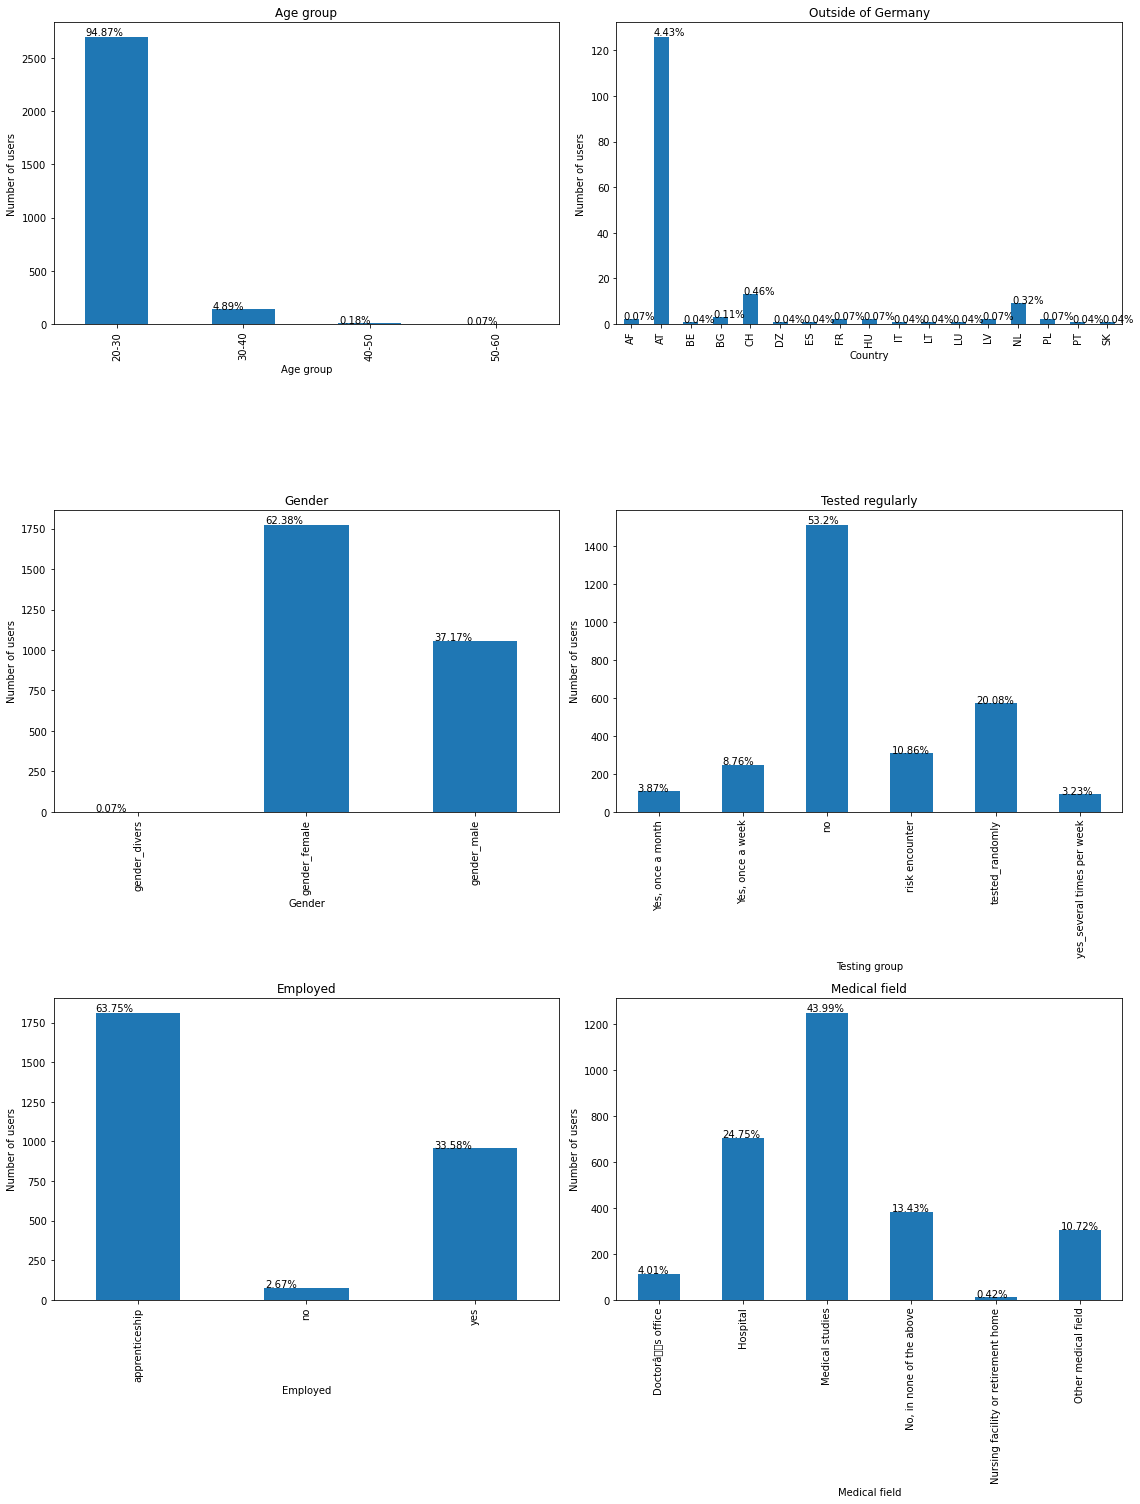

In [31]:
Display.header('Only from public event', 'h2')

df = get_demograpgics()
count_all = df.shape[0]
df = df[df['CHANNEL'] == 'public_event']
percent = round(100 * df.shape[0] / count_all, 1)
print(f'Number of participants: {df.shape[0]}, ({percent}%)')
draw(df)

In [45]:
from datetime import date

from datetime import date, timedelta

class ExposureAnalysis:
    
    @staticmethod
    def get_exposure_dates():
        dates = []
        instance_date = datetime(2021, 4, 7)
        while instance_date.date() < datetime.now().date():
            dates.append(instance_date)
            instance_date = instance_date + timedelta(days=28)
        return dates

    @staticmethod
    def calc_enrollment_group(enrolment_date, exposure_dates):
        for i in range(len(exposure_dates)):
            d = exposure_dates[len(exposure_dates)-i-1]
            if enrolment_date.date() >= d.date():
                return d
            
    @staticmethod
    def exposure_submissions(participants_df, exposure_dates):
        result = participants_df[~participants_df['ENROLED_ON'].isnull()][['ALP_ID', 'ENROLED_ON']].copy()
        result['total'] = 1
        result['ENROLMENT_GROUP'] = result.apply(lambda row : ExposureAnalysis.calc_enrollment_group(
            row['ENROLED_ON'], exposure_dates), axis = 1)
        r = responses_df[responses_df['QUESTIONNAIRE'] == study.questionnaires()['Q3']]
        instance_date = datetime(2021, 4, 7)
        instance_number = 1
        while instance_date.date() < datetime.now().date():
            df = r[(r['AUTHORED'] >= instance_date) & (r['AUTHORED'] < instance_date + timedelta(days=28))].copy()
            column_name = f'Q3:{instance_date.strftime("%d.%m")}'
            df[column_name] = 1
            df = df[['ALP_ID', column_name]].drop_duplicates()
            result = pd.merge(result, df, how='left', on='ALP_ID')
            result[column_name] = result[column_name].fillna(0).astype(int)
            instance_date = instance_date + timedelta(days=28)
            instance_number += 1
        result = result.drop(columns=['ALP_ID', 'ENROLED_ON'])
        result = result.groupby(by=['ENROLMENT_GROUP']).sum()
        return result
    
    @staticmethod
    def show_submissions(df):
        exposure_dates = ExposureAnalysis.get_exposure_dates()[1:]
        exposure_dates.append(exposure_dates[-1] + timedelta(days=28))
        df = ExposureAnalysis.exposure_submissions(df, exposure_dates)
        Display.header(f'Count submissions of every Q3 (exposure questionnaire)', 'h3')
        Display.frame(df)

        df2 = df.copy().astype(str)
        for i in range(len(exposure_dates)):
            index = exposure_dates[i].strftime("%Y-%m-%d")
            if index in df.index:
                reference = df.loc[index]['total']
                offset = 1
                column_name = f'Q3:{exposure_dates[i+offset].strftime("%d.%m")}'
                while (column_name in df.columns):
                    df2.loc[index][column_name] = f'{round(100 * (reference - df.loc[index][column_name]) / reference)}%' \
                        if reference > 0 else '0%'
                    reference = df.loc[index][column_name]
                    offset += 1
                    column_name = f'Q3:{exposure_dates[i+offset].strftime("%d.%m")}'      

        df2.replace('0', '-', inplace=True)
        df2.replace('1', '-', inplace=True) # fixing an issue that there is "1" in cells where they chould be 0
        Display.header(f'Loss of participants (in % from previous month)', 'h3')
        print('percentage = (last_month - this_month) / last_month')
        Display.frame(df2)
        
        df3 = df[['total', 'Q3:09.02']].copy()
#         df3['percent_total'] = 100 * df3['Q3:09.02'] / df3['total']
        df3['percent'] = round(100 * df3['Q3:09.02'] / df3['Q3:09.02'].sum(), 1)
        print(df3['Q3:09.02'].sum())
        Display.header(f'Percentage from total', 'h3')
        Display.frame(df3)

    
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','participant_gender', 'GENDER') \
    .add_choice('personal_info','regular_testing', 'REGULAR_TESTED') \
    .add_choice('personal_info','country_of_residence', 'COUNTRY') \
    .add_answer('personal_info','participant_year_born', 'BIRTH_YEAR') \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .get()

Display.header(f'Exposure questionnaire', 'h1')
Display.text('Triggered on Wednesday ever 28 days:')
dates = ExposureAnalysis.get_exposure_dates()
for d in dates:
    print(f'{d.strftime("%d.%m.%Y")}, week: {to_week_number(d)}')
    
Display.header(f'All participants excluding public event', 'h2')
temp = df[df['CHANNEL'] != 'public_event']
ExposureAnalysis.show_submissions(temp)

Display.header(f'Only participants from public event', 'h2')
temp = df[df['CHANNEL'] == 'public_event']
ExposureAnalysis.show_submissions(temp)

07.04.2021, week: 2021, 14
05.05.2021, week: 2021, 18
02.06.2021, week: 2021, 22
30.06.2021, week: 2021, 26
28.07.2021, week: 2021, 30
25.08.2021, week: 2021, 34
22.09.2021, week: 2021, 38
20.10.2021, week: 2021, 42
17.11.2021, week: 2021, 46
15.12.2021, week: 2021, 50
12.01.2022, week: 2022, 2
09.02.2022, week: 2022, 6
09.03.2022, week: 2022, 10


,total,Q3:07.04,Q3:05.05,Q3:02.06,Q3:30.06,Q3:28.07,Q3:25.08,Q3:22.09,Q3:20.10,Q3:17.11,Q3:15.12,Q3:12.01,Q3:09.02,Q3:09.03
ENROLMENT_GROUP,,,,,,,,,,,,,,
2021-05-05,294,0,0,179,161,137,84,103,95,43,69,67,47,0
2021-06-02,805,0,0,0,530,479,303,318,317,157,252,238,199,0
2021-06-30,404,0,0,0,0,245,157,178,149,84,127,113,95,0
2021-07-28,170,0,0,0,0,0,63,58,51,29,36,34,27,0
2021-08-25,226,0,0,0,0,0,0,86,67,38,48,41,31,0
2021-09-22,350,0,0,0,0,0,0,0,129,55,63,54,51,0
2021-10-20,340,0,0,0,0,0,0,0,0,89,83,82,57,0
2021-11-17,878,0,0,0,0,0,0,0,0,0,380,280,210,0
2021-12-15,576,0,0,0,1,1,0,0,0,0,0,236,173,0


percentage = (last_month - this_month) / last_month


,total,Q3:07.04,Q3:05.05,Q3:02.06,Q3:30.06,Q3:28.07,Q3:25.08,Q3:22.09,Q3:20.10,Q3:17.11,Q3:15.12,Q3:12.01,Q3:09.02,Q3:09.03
ENROLMENT_GROUP,,,,,,,,,,,,,,
2021-05-05,294,-,-,39%,10%,15%,39%,-23%,8%,55%,-60%,3%,30%,100%
2021-06-02,805,-,-,-,34%,10%,37%,-5%,0%,50%,-61%,6%,16%,100%
2021-06-30,404,-,-,-,-,39%,36%,-13%,16%,44%,-51%,11%,16%,100%
2021-07-28,170,-,-,-,-,-,63%,8%,12%,43%,-24%,6%,21%,100%
2021-08-25,226,-,-,-,-,-,-,62%,22%,43%,-26%,15%,24%,100%
2021-09-22,350,-,-,-,-,-,-,-,63%,57%,-15%,14%,6%,100%
2021-10-20,340,-,-,-,-,-,-,-,-,74%,7%,1%,30%,100%
2021-11-17,878,-,-,-,-,-,-,-,-,-,57%,26%,25%,100%
2021-12-15,576,-,-,-,-,-,-,-,-,-,-,59%,27%,100%


1254


,total,Q3:09.02,percent
ENROLMENT_GROUP,,,
2021-05-05,294,47,3.7
2021-06-02,805,199,15.9
2021-06-30,404,95,7.6
2021-07-28,170,27,2.2
2021-08-25,226,31,2.5
2021-09-22,350,51,4.1
2021-10-20,340,57,4.5
2021-11-17,878,210,16.7
2021-12-15,576,173,13.8


,total,Q3:07.04,Q3:05.05,Q3:02.06,Q3:30.06,Q3:28.07,Q3:25.08,Q3:22.09,Q3:20.10,Q3:17.11,Q3:15.12,Q3:12.01,Q3:09.02,Q3:09.03
ENROLMENT_GROUP,,,,,,,,,,,,,,
2021-06-30,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-07-28,1761,0,0,0,0,0,1174,666,487,185,242,197,117,1
2021-08-25,975,0,0,0,0,0,0,318,203,85,110,80,51,0
2021-09-22,70,0,0,0,0,0,0,1,12,3,8,6,2,0
2021-10-20,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-15,30,0,0,0,0,0,0,0,0,0,0,5,6,0
2022-01-12,4,0,0,0,0,0,0,0,0,0,0,0,1,0
2022-02-09,3,0,0,0,0,0,0,0,0,0,0,0,0,0


percentage = (last_month - this_month) / last_month


,total,Q3:07.04,Q3:05.05,Q3:02.06,Q3:30.06,Q3:28.07,Q3:25.08,Q3:22.09,Q3:20.10,Q3:17.11,Q3:15.12,Q3:12.01,Q3:09.02,Q3:09.03
ENROLMENT_GROUP,,,,,,,,,,,,,,
2021-06-30,2,-,-,-,-,100%,0%,0%,0%,0%,0%,0%,0%,0%
2021-07-28,1761,-,-,-,-,-,33%,43%,27%,62%,-31%,19%,41%,99%
2021-08-25,975,-,-,-,-,-,-,67%,36%,58%,-29%,27%,36%,100%
2021-09-22,70,-,-,-,-,-,-,-,83%,75%,-167%,25%,67%,100%
2021-10-20,-,-,-,-,-,-,-,-,-,100%,0%,0%,0%,0%
2021-12-15,30,-,-,-,-,-,-,-,-,-,-,83%,-20%,100%
2022-01-12,4,-,-,-,-,-,-,-,-,-,-,-,75%,100%
2022-02-09,3,-,-,-,-,-,-,-,-,-,-,-,-,100%


177


,total,Q3:09.02,percent
ENROLMENT_GROUP,,,
2021-06-30,2,0,0.0
2021-07-28,1761,117,66.1
2021-08-25,975,51,28.8
2021-09-22,70,2,1.1
2021-10-20,1,0,0.0
2021-12-15,30,6,3.4
2022-01-12,4,1,0.6
2022-02-09,3,0,0.0


In [52]:
df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation().get()

print(f'All users: {df.shape[0]}')

df = df[df['LAST_DONATION'] >= datetime(2022, 2, 9)]
print(f'Users who donated data after 09.02.2022: {df.shape[0]}')

Display.frame(df,5)

All users: 8940
Users who donated data after 09.02.2022: 2123


,Unnamed: 0,ALP_ID,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,LAST_DONATION
2,3,8377,anonymous,enrolled,2021-12-14,NaT,2021-12-14,2022-02-18
13,14,2651,anonymous,enrolled,2021-06-09,NaT,2021-06-09,2022-03-07
34,35,6029,anonymous,enrolled,2021-09-10,NaT,2021-09-10,2022-02-10
42,43,2014,anonymous,enrolled,2021-07-08,NaT,2021-07-08,2022-02-09
50,51,6975,anonymous,enrolled,2021-10-14,NaT,2021-10-14,2022-03-04


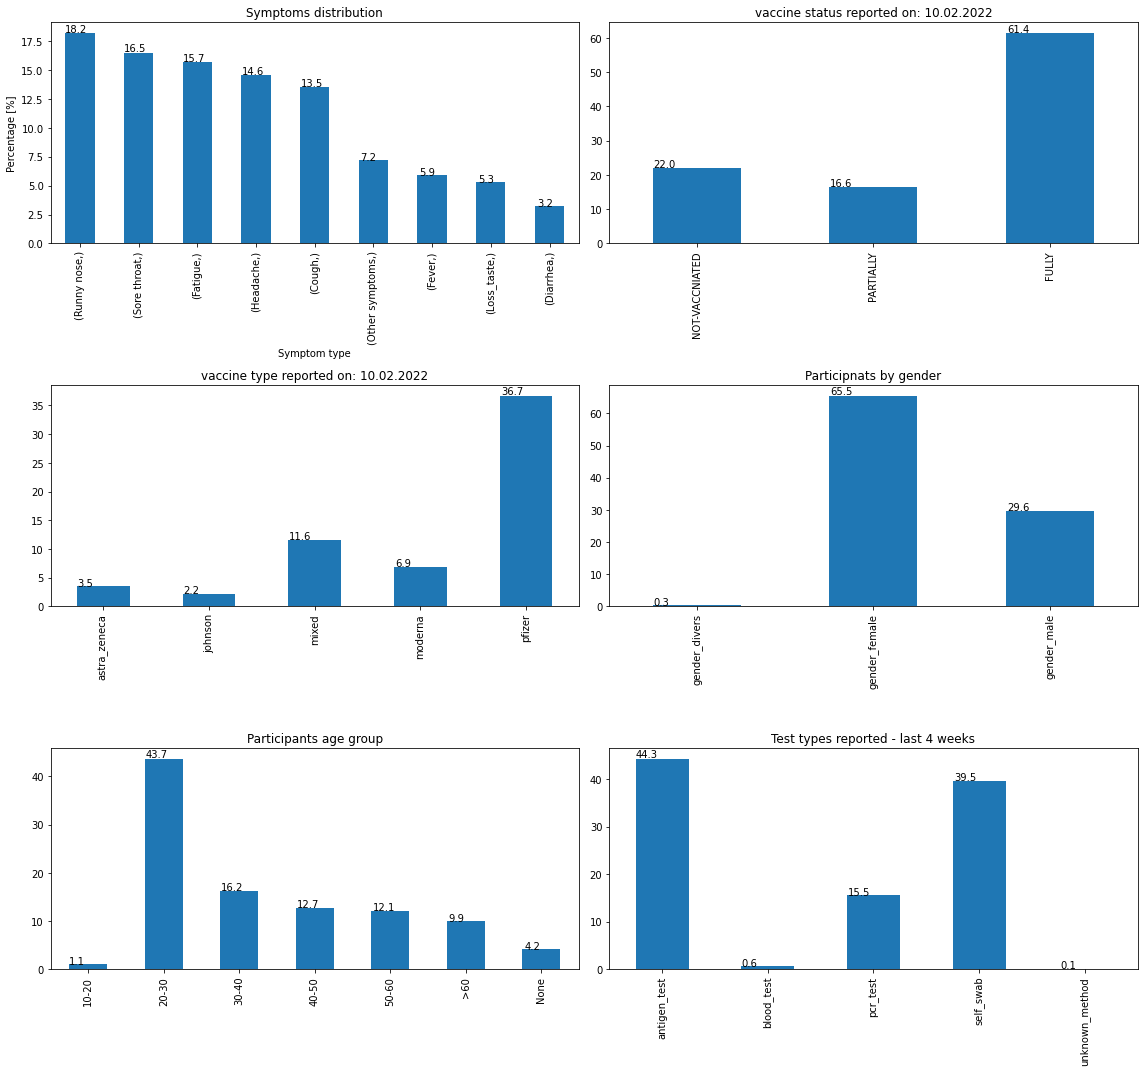

In [34]:
from ecov_utils import Vaccination 
from datetime import datetime, timedelta
from utils import get_age_group

last_donation = responses_df['AUTHORED'].max()

rb = ResponsesBuilder(responses_df)
df = rb.get_choice('SYMPTOMS', 'which_new_symptoms')
vc = round(100 * df[['SYMPTOMS']].value_counts() / df.shape[0], 1)

Display.header('Charts in the study application', 'h1')
Display.text('The charts in this section are available for users in the application')

df = original_participants_df[original_participants_df['STATUS'] != 'withdrawn']
Display.text(f'Participants with valid consent: {df.shape[0]}')
df = original_participants_df[original_participants_df['STATUS'] == 'suspended']
Display.text(f'Participants that left study: {df.shape[0]}')

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(16,15))

vc.plot(kind="bar", ax=ax1, title=f'Symptoms distribution', 
        xlabel='Symptom type', ylabel='Percentage [%]');


v = Vaccination(original_participants_df, responses_df)

day = datetime.now()
df = v.get_vaccine_status(day)

temp = df[df['status'] != 'UNKNOWN']
value_cnts = round(100 * temp['status'].value_counts()[['NOT-VACCNIATED', 'PARTIALLY', 'FULLY']] / temp.shape[0], 1)
value_cnts.plot(kind='bar', ax=ax2, title=f'vaccine status reported on: {day.strftime("%d.%m.%Y")}')

value_cnts = round(100 * df['type'].value_counts().sort_index() / df.shape[0], 1)
value_cnts.plot(kind='bar', ax=ax3, title=f'vaccine type reported on: {day.strftime("%d.%m.%Y")}')

df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_choice('personal_info','participant_gender', 'GENDER') \
    .add_answer('personal_info','participant_year_born', 'BIRTH_YEAR') \
    .get()

df["BIRTH_YEAR"] = df["BIRTH_YEAR"].fillna(0).astype(int)
df['AGE_GROUP'] = df.apply(lambda row : get_age_group(row['BIRTH_YEAR']), axis = 1)

value_cnts = round(100 * df['GENDER'].value_counts().sort_index() / df.shape[0], 1)
value_cnts.plot(kind='bar', ax=ax4, title='Participnats by gender')

value_cnts = round(100 * df['AGE_GROUP'].value_counts().sort_index() / df.shape[0], 1)
value_cnts.plot(kind='bar', ax=ax5, title='Participants age group');

NUM_OF_WEEKS = 4
threshold = last_donation - timedelta(days=7*NUM_OF_WEEKS)

tests = TestManager(responses_df).get()
tests = tests[tests['AUTHORED'] > threshold]
value_cnts = round(100 * tests['METHOD'].value_counts().sort_index() / tests.shape[0], 1)
value_cnts.plot(kind='bar', ax=ax6, title=f'Test types reported - last {NUM_OF_WEEKS} weeks');

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    Display.tag_bars(ax)
        
fig.tight_layout()

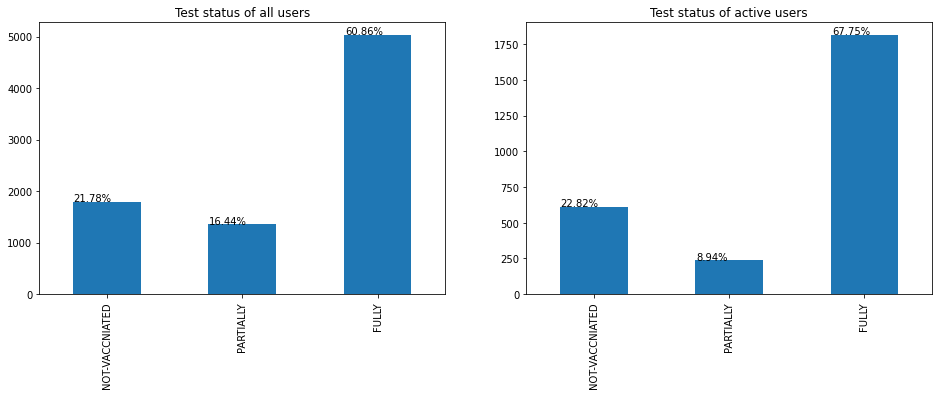

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

relevant_status = ['NOT-VACCNIATED', 'PARTIALLY', 'FULLY']

# All participants

v = Vaccination(original_participants_df, responses_df)
df = v.get_vaccine_status(datetime.now())  
value_cnts1 = df[df['status'].isin(relevant_status)]['status'].value_counts()[relevant_status]

# Only participants who donated in the last 6 weeks

NUM_OF_WEEKS = 6
threshold = last_donation - timedelta(days=7*NUM_OF_WEEKS)

participants_df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .get()

participants_df = participants_df[participants_df['LAST_DONATION'] >= threshold]
filtered_responses = responses_df[responses_df['ALP_ID'].isin(participants_df['ALP_ID'].unique())]
v = Vaccination(participants_df, filtered_responses)
df = v.get_vaccine_status(datetime.now())  
value_cnts2 = df[df['status'].isin(relevant_status)]['status'].value_counts()[relevant_status]

# Draw charts

Display.header('Vaccination status', 'h2')
Display.text(f'Active users = Users who that submitted any questionnaire in the last {NUM_OF_WEEKS} weeks (since: {threshold.strftime("%d.%m.%Y")})')
value_cnts1.plot(kind='bar', ax=ax1, title=f'Test status of all users');
Display.tag_bars(ax1, original_participants_df.shape[0])
value_cnts2.plot(kind='bar', ax=ax2, title=f'Test status of active users');
Display.tag_bars(ax2, participants_df.shape[0])

In [36]:
from study import EcovStudy, ParticipantsBuilder

df = ParticipantsBuilder(EcovStudy(), original_participants_df, responses_df) \
    .add_choice('covid_first_vaccine', 'corona_vaccination_received', '1ST_DOSE') \
    .add_choice('covid_first_vaccine', 'which_vaccine_received', '1ST_VACCINE_TYPE') \
    .add_answer('covid_first_vaccine', 'when_vaccinated_first_time', '1ST_VACCINE_DATE') \
    .add_choice('covid_second_vaccine','has_received_second_vacciation', '2ND_DOSE') \
    .add_choice('covid_second_vaccine', 'which_vaccine_received', '2ND_VACCINE_TYPE') \
    .add_answer('covid_second_vaccine', 'when_vaccinated_second_time', '2ND_VACCINE_DATE') \
    .add_choice('personal_info','country_of_residence', 'COUNTRY') \
    .add_last_donation() \
    .get()

Display.header('Testing', 'h1')
Display.header('Sputnik vaccine', 'h2')

count_sputnik_participants = df[df['1ST_VACCINE_TYPE'] == 'sputnik'].shape[0]
print(f'Number of participant reported Sputnik: {count_sputnik_participants}')

Number of participant reported Sputnik: 2


,0
SYMPTOMS,
Runny nose,1524
Sore throat,1380
Fatigue,1317
Headache,1220
Cough,1133
Other symptoms,603
Fever,496
Loss_taste,445
Diarrhea,265


Number of participant reported symptoms: 1511
Participants from public event that reported symptoms: 284
Participants not from public event that reported symptoms: 1227


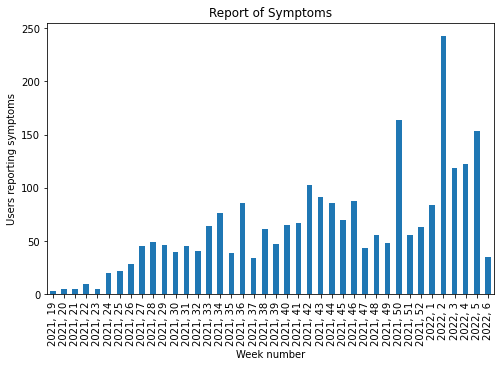

In [37]:
from ecov_utils import Vaccination 
from datetime import datetime, timedelta

last_donation = responses_df['AUTHORED'].max()
NUM_OF_WEEKS = 4
threshold = last_donation - timedelta(days=7*NUM_OF_WEEKS)

rb = ResponsesBuilder(responses_df)
df = rb.get_choice('SYMPTOMS', 'which_new_symptoms')
vc = round(df[['SYMPTOMS']].value_counts(), 1)
Display.frame(vc.to_frame())

count_users_with_symptoms = len(df['ALP_ID'].unique())

Display.header('Symptoms', 'h2')
print(f'Number of participant reported symptoms: {count_users_with_symptoms}')

participants_df = ParticipantsBuilder(EcovStudy(), original_participants_df, responses_df) \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .get()

s = df.groupby("ALP_ID").agg({"SYMPTOMS": "nunique"}).reset_index()
participants_df = pd.merge(s, participants_df, how='left', on='ALP_ID')

count = participants_df[participants_df['CHANNEL'] == 'public_event'].shape[0]
print(f'Participants from public event that reported symptoms: {count}')
count = participants_df[participants_df['CHANNEL'] != 'public_event'].shape[0]
print(f'Participants not from public event that reported symptoms: {count}')

df = rb.get_choice('symptoms', 'which_new_symptoms')[['ALP_ID', 'AUTHORED']]
df = df.drop_duplicates(subset=['ALP_ID', 'AUTHORED'], keep='last')

fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
plot_over_weeks(df, 'AUTHORED', ax1, 'Report of Symptoms', \
                'Users reporting symptoms', 'Week number')

In [38]:
participants_df = ParticipantsBuilder(EcovStudy(), original_participants_df, responses_df) \
    .add_choice('personal_info','study_discovery', 'CHANNEL') \
    .add_last_donation() \
    .get()

rb = ResponsesBuilder(responses_df)
df = rb.get_choice('COUNT_SYMPTOMS', 'which_new_symptoms')
s = df.groupby("ALP_ID").agg({"COUNT_SYMPTOMS": "count"}).sort_values(by=['COUNT_SYMPTOMS'], ascending=False).reset_index()
df = pd.merge(s, participants_df, how='left', on='ALP_ID')
Display.frame(df, 30)

,ALP_ID,COUNT_SYMPTOMS,Unnamed: 0,EXTERNAL_ID,STATUS,START_DATE,END_DATE,ENROLED_ON,CHANNEL,LAST_DONATION
0,7762,66,4299,anonymous,enrolled,2021-11-28,NaT,2021-11-28,friends_family,2022-02-04
1,10111,55,7776,anonymous,enrolled,2022-01-28,NaT,2022-01-28,facebook_ad,2022-01-28
2,2824,41,2303,anonymous,enrolled,2021-06-20,NaT,2021-06-20,NaN,2022-02-04
3,10415,41,8005,anonymous,enrolled,2022-02-04,NaT,2022-02-04,google_search,2022-02-07
4,9703,41,5965,anonymous,enrolled,2022-01-18,NaT,2022-01-18,google_search,2022-01-18
5,1903,39,1721,anonymous,enrolled,2021-07-11,NaT,2021-07-11,other_source,2022-01-12
6,1824,37,1598,anonymous,enrolled,2021-06-18,NaT,2021-06-18,NaN,2022-01-12
7,1945,35,2651,anonymous,enrolled,NaT,NaT,2021-07-01,NaN,2022-01-24
8,2972,34,1510,anonymous,enrolled,2021-06-16,NaT,2021-06-16,NaN,2022-01-12
9,6713,34,4860,anonymous,enrolled,2021-10-05,NaT,2021-10-05,google_search,2022-01-23


In [39]:
v = Vaccination(original_participants_df, responses_df)
tests = v.get_tests()

pos_tests = tests[tests['RESULT'] == 'test_result_pos']

Display.header('Psotive tests and reported infections', 'h2')
print(f'Participants reporting postive tests: {len(pos_tests["ALP_ID"].unique())}')

df = ParticipantsBuilder(EcovStudy(), original_participants_df, responses_df) \
    .add_choice('personal_info', 'corona_already_infected', 'ALREADY_INFECTED') \
    .add_last_donation() \
    .get()

print(f'Participants answering they they have been infected in demographics: {len(df[df["ALREADY_INFECTED"] == "yes"]["ALP_ID"].unique())}')
      
lst1 = pos_tests['ALP_ID'].unique()
lst2 = df[df['ALREADY_INFECTED'] == 'yes']['ALP_ID'].unique()
intersect_lst = list(set(lst1) & set(lst2))
print(f'Participants that reported infection in demographics and also a positive test: {len(intersect_lst)}')

Participants reporting postive tests: 799
Participants answering they they have been infected in demographics: 1549
Participants that reported infection in demographics and also a positive test: 596


In [40]:
Display.header('Max tests', 'h2')
tests_per_user = tests.groupby('ALP_ID').TEST_DATE.nunique()
print(f'Max number of tests reported by a single user: {tests_per_user.max()}')

Max number of tests reported by a single user: 93


In [41]:
df = ParticipantsBuilder(EcovStudy(), original_participants_df, responses_df) \
    .add_choice('covid_first_vaccine', 'corona_vaccination_received', '1ST_DOSE') \
    .add_choice('covid_second_vaccine','has_received_second_vacciation', '2ND_DOSE') \
    .add_choice('covid_booster_vaccine','has_received_booster_vacciation', '3RD_DOSE') \
    .add_last_donation() \
    .get()

special_values = ['already_infected', 'vaccine_undesired']

Display.header('New answers are used', 'h2')

answer = 'already_infected'
print(f'Infection reported in 1st dose: {df[(df["1ST_DOSE"] == answer)].shape[0]}')
print(f'Infection reported in 2nd dose: {df[(df["2ND_DOSE"] == answer)].shape[0]}')
print(f'Infection reported in 3rd dose: {df[(df["3RD_DOSE"] == answer)].shape[0]}')

answer = 'vaccine_undesired'
print(f'Undesired 1st dose: {df[(df["1ST_DOSE"] == answer)].shape[0]}')
print(f'Undesired 2nd dose: {df[(df["2ND_DOSE"] == answer)].shape[0]}')
print(f'Undesired booster: {df[(df["3RD_DOSE"] == answer)].shape[0]}')

print(f'Recieved booster: {df[(df["3RD_DOSE"] == "yes")].shape[0]}')

Infection reported in 1st dose: 163
Infection reported in 2nd dose: 40
Infection reported in 3rd dose: 11
Undesired 1st dose: 585
Undesired 2nd dose: 3
Undesired booster: 8
Recieved booster: 1689


In [42]:
participants_df = ParticipantsBuilder(EcovStudy(), original_participants_df, responses_df) \
    .add_choice('personal_info', 'corona_already_infected', 'ALREADY_INFECTED') \
    .add_last_donation() \
    .get()

participants_df = participants_df[participants_df['ALREADY_INFECTED'] == 'yes']
filtered_responses = responses_df[responses_df['ALP_ID'].isin(participants_df['ALP_ID'].unique())]

v = Vaccination(participants_df, filtered_responses)
df = v.get_vaccine_status(datetime.now())  

value_cnts = df['status'].value_counts()
value_cnts.head()

FULLY             773
NOT-VACCNIATED    428
PARTIALLY         343
UNKNOWN             5
Name: status, dtype: int64

In [43]:
study = EcovStudy()
builder = ParticipantsBuilder(study, original_participants_df, responses_df)
participants_df = builder.add_last_donation().get() 

date_4_month_ago = datetime.now() - timedelta(days=120)
df = df[df['ENROLED_ON'] < date_4_month_ago]
Display.frame(df, 5)
print(df.shape[0])

KeyError: 'ENROLED_ON'

In [ ]:
participants_df = ParticipantsBuilder(study, original_participants_df, responses_df) \
    .add_last_donation() \
    .add_all_submissions() \
    .get() 

reference_date = datetime(2021, 11, 9)
df = participants_df[participants_df['LAST_DONATION'] >= reference_date]

filtered_responses = responses_df[responses_df['ALP_ID'].isin(df['ALP_ID'].unique())]
v = Vaccination(df, filtered_responses)
vaccine_df = v.get_vaccine_status(datetime.now()) 
challenges_df = df.copy().reset_index()
challenges_df['status'] = vaccine_df['status']

print(f'Participants donating after {reference_date.strftime("%d.%m.%Y")}: {df.shape[0]}')
challenge1_df = challenges_df[challenges_df['status'].isin(['FULLY', 'NOT-VACCNIATED'])]
print(f'Participants who completed challenge 1: {challenge1_df.shape[0]}')
challenge2_df = challenge1_df[challenge1_df['Q3'] >= 3]
print(f'Participants who completed challenge 2: {challenge2_df.shape[0]}')

In [39]:
from datetime import datetime
from lib.study import FilterUsers

df = FilterUsers(responses_df) \
    .filter_authored_date(datetime(2021, 8, 22)) \
    .filter_authored_date(datetime(2021, 8, 25)) \
    .filter_authored_date(datetime(2021, 10, 20)) \
    .get().reset_index()

ids = df[df['2021-08-22 Qs'] == 6]['ALP_ID'].unique()
# ids = df['ALP_ID'].unique()

df = responses_df[responses_df['ALP_ID'].isin(ids)].groupby(['ALP_ID', 'AUTHORED', 'QUESTIONNAIRE']).aggregate({'QUESTIONNAIRE_ID': 'nunique'})
Display.frame(df)